# 🌿 Biodiversity Impact Assessment for Industrial Operations
### GBIF + Satellite Imagery Analysis Pipeline

> **Use Case:** Environmental Due Diligence for Oil & Gas / Mining / Infrastructure projects  
> **Output:** Quantitative biodiversity risk metrics, time-series trends, and spatial overlays to support EIA (Environmental Impact Assessment) reporting

---

**Workflow Overview:**
1. 📍 Define study area via user-drawn grid
2. 🔍 Fetch & quality-filter GBIF occurrence data
3. 📊 Compute biodiversity & threat metrics (richness, IUCN risk, endemic species)
4. 📈 Time-series trend analysis of species observations
5. 🛰️ Satellite imagery integration (NDVI, land cover change via Google Earth Engine)
6. 🗺️ Interactive spatial risk maps
7. 📋 Automated PDF-ready summary report

---
**⚠️ Requirements:** Google account (for GEE), GBIF account (optional but recommended for large queries)

## 📦 0. Install Dependencies

In [ ]:
%%capture
!pip install pygbif folium branca matplotlib seaborn scipy statsmodels \
             geopandas shapely pyproj requests pandas numpy plotly \
             earthengine-api geemap ipywidgets kaleido

In [ ]:
# Core imports
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import warnings
import requests
from datetime import datetime
from shapely.geometry import box, Point, Polygon

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium.plugins import HeatMap, MarkerCluster

# Stats
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# GBIF
from pygbif import occurrences as occ
from pygbif import species as sp
from pygbif import maps

# Colab utilities
from IPython.display import display, HTML, IFrame
import ipywidgets as widgets

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

print('✅ All imports successful')

✅ All imports successful


## 📍 1. Define Study Area (User Grid)

Specify your area of interest as a bounding box. You can:
- **Option A:** Enter coordinates manually below
- **Option B:** Use the interactive map widget to draw a rectangle

The grid will be subdivided into cells for spatial analysis.

In [ ]:
# =============================================================
# ✏️  USER CONFIGURATION — Edit this block
# =============================================================

# Example: Niger Delta region (major oil production area)
# Change these coordinates to your area of interest
CONFIG = {
    # Bounding box [min_lon, min_lat, max_lon, max_lat]
    'bbox': [5.0, 4.5, 8.0, 6.5],

    # Grid resolution (degrees) — smaller = finer grid, more API calls
    'grid_resolution': 0.5,

    # Time range for observations
    'year_start': 2000,
    'year_end': 2024,

    # Max GBIF records per request (max 300 per call, paginated)
    'max_records': 5000,

    # Project name (for report)
    'project_name': 'Niger Delta Block Exploration - EIA Biodiversity Assessment',
    'company': 'Example Energy Corp',

    # GBIF credentials (optional — increases rate limits)
    'gbif_user': '',       # your GBIF username
    'gbif_email': '',      # your email
    'gbif_password': '',   # your password
}

# Unpack bbox
MIN_LON, MIN_LAT, MAX_LON, MAX_LAT = CONFIG['bbox']

print(f"📍 Study Area: [{MIN_LON}°E, {MIN_LAT}°N] → [{MAX_LON}°E, {MAX_LAT}°N]")
print(f"📐 Area: ~{(MAX_LON-MIN_LON) * 111 * (MAX_LAT-MIN_LAT) * 111:.0f} km²")
print(f"🔲 Grid resolution: {CONFIG['grid_resolution']}° (~{CONFIG['grid_resolution']*111:.1f} km)")
print(f"📅 Time range: {CONFIG['year_start']}–{CONFIG['year_end']}")

📍 Study Area: [5.0°E, 4.5°N] → [8.0°E, 6.5°N]
📐 Area: ~73926 km²
🔲 Grid resolution: 0.5° (~55.5 km)
📅 Time range: 2000–2024


In [ ]:
# Build grid cells
def build_grid(min_lon, min_lat, max_lon, max_lat, resolution):
    """Create a regular grid of bounding boxes over the study area."""
    cells = []
    lons = np.arange(min_lon, max_lon, resolution)
    lats = np.arange(min_lat, max_lat, resolution)
    for lon in lons:
        for lat in lats:
            cells.append({
                'cell_id': f"{lon:.2f}_{lat:.2f}",
                'min_lon': lon, 'min_lat': lat,
                'max_lon': min(lon + resolution, max_lon),
                'max_lat': min(lat + resolution, max_lat),
                'center_lon': lon + resolution / 2,
                'center_lat': lat + resolution / 2,
                'geometry': box(lon, lat, min(lon+resolution, max_lon), min(lat+resolution, max_lat))
            })
    return gpd.GeoDataFrame(cells, crs='EPSG:4326')

grid_gdf = build_grid(MIN_LON, MIN_LAT, MAX_LON, MAX_LAT, CONFIG['grid_resolution'])
print(f"✅ Created grid with {len(grid_gdf)} cells")
print(grid_gdf[['cell_id','min_lon','min_lat','max_lon','max_lat']].head())

✅ Created grid with 24 cells
     cell_id  min_lon  min_lat  max_lon  max_lat
0  5.00_4.50   5.0000   4.5000   5.5000   5.0000
1  5.00_5.00   5.0000   5.0000   5.5000   5.5000
2  5.00_5.50   5.0000   5.5000   5.5000   6.0000
3  5.00_6.00   5.0000   6.0000   5.5000   6.5000
4  5.50_4.50   5.5000   4.5000   6.0000   5.0000


In [ ]:
# Interactive map preview of study area
center_lat = (MIN_LAT + MAX_LAT) / 2
center_lon = (MIN_LON + MAX_LON) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=7,
               tiles='CartoDB positron')

# Draw grid
for _, cell in grid_gdf.iterrows():
    folium.Rectangle(
        bounds=[[cell.min_lat, cell.min_lon], [cell.max_lat, cell.max_lon]],
        color='#e74c3c', weight=1.5, fill=True, fill_opacity=0.05,
        tooltip=f"Cell: {cell.cell_id}"
    ).add_to(m)

# Study area outline
folium.Rectangle(
    bounds=[[MIN_LAT, MIN_LON], [MAX_LAT, MAX_LON]],
    color='#e74c3c', weight=3, fill=False
).add_to(m)

folium.Marker([center_lat, center_lon],
              popup=CONFIG['project_name'],
              icon=folium.Icon(color='red', icon='industry', prefix='fa')).add_to(m)

m.save('/content/study_area.html')
display(m)

## 🔍 2. Fetch & Quality-Filter GBIF Data

We apply a multi-layer quality filter pipeline based on GBIF's own data quality flags and scientific standards.

In [ ]:
def fetch_gbif_page(min_lon, min_lat, max_lon, max_lat, year_start, year_end,
                    offset=0, limit=300):
    """Fetch one page of GBIF occurrences for a bounding box."""
    result = occ.search(
        geometry=f'POLYGON(({min_lon} {min_lat},{max_lon} {min_lat},{max_lon} {max_lat},{min_lon} {max_lat},{min_lon} {min_lat}))',
        year=f'{year_start},{year_end}',
        hasCoordinate=True,
        hasGeospatialIssue=False,
        occurrenceStatus='PRESENT',
        limit=limit,
        offset=offset
    )
    return result

def fetch_gbif_all(min_lon, min_lat, max_lon, max_lat, year_start, year_end, max_records=5000):
    """Fetch all GBIF records for a bbox up to max_records."""
    all_records = []
    offset = 0
    limit = 300

    first = fetch_gbif_page(min_lon, min_lat, max_lon, max_lat, year_start, year_end, 0, 1)
    total = first.get('count', 0)
    print(f"   📊 Total available records: {total:,}")

    to_fetch = min(total, max_records)

    while offset < to_fetch:
        result = fetch_gbif_page(min_lon, min_lat, max_lon, max_lat,
                                  year_start, year_end, offset, limit)
        records = result.get('results', [])
        if not records:
            break
        all_records.extend(records)
        offset += limit
        if offset % 900 == 0:
            print(f"   ⏳ Fetched {len(all_records):,}/{to_fetch:,}...")

    return all_records, total

print("🔄 Fetching GBIF data for entire study area...")
raw_records, total_available = fetch_gbif_all(
    MIN_LON, MIN_LAT, MAX_LON, MAX_LAT,
    CONFIG['year_start'], CONFIG['year_end'],
    CONFIG['max_records']
)
print(f"✅ Downloaded {len(raw_records):,} raw records")

🔄 Fetching GBIF data for entire study area...
   📊 Total available records: 46,464
   ⏳ Fetched 900/5,000...
   ⏳ Fetched 1,800/5,000...
   ⏳ Fetched 2,700/5,000...
   ⏳ Fetched 3,600/5,000...
   ⏳ Fetched 4,500/5,000...
✅ Downloaded 5,100 raw records


In [ ]:
# Convert to DataFrame
FIELDS = [
    'gbifID','species','genus','family','order','class','phylum','kingdom',
    'decimalLatitude','decimalLongitude','coordinateUncertaintyInMeters',
    'year','month','day','eventDate',
    'basisOfRecord','institutionCode','datasetName',
    'occurrenceStatus','taxonRank','vernacularName',
    'countryCode','stateProvince','locality',
    'coordinatePrecision','depth','elevation',
    'issue','iucnRedListCategory'
]

df_raw = pd.json_normalize(raw_records)

# Keep only available fields
avail = [f for f in FIELDS if f in df_raw.columns]
df_raw = df_raw[avail].copy()

print(f"Raw dataset shape: {df_raw.shape}")
print(f"\nColumns available: {list(df_raw.columns)}")

Raw dataset shape: (5100, 26)

Columns available: ['gbifID', 'species', 'genus', 'family', 'order', 'class', 'phylum', 'kingdom', 'decimalLatitude', 'decimalLongitude', 'coordinateUncertaintyInMeters', 'year', 'month', 'day', 'eventDate', 'basisOfRecord', 'institutionCode', 'datasetName', 'occurrenceStatus', 'taxonRank', 'vernacularName', 'countryCode', 'stateProvince', 'locality', 'elevation', 'iucnRedListCategory']


In [ ]:
# ============================================================
# 🧹 QUALITY FILTER PIPELINE
# ============================================================

print("=" * 60)
print("QUALITY FILTER PIPELINE")
print("=" * 60)

df = df_raw.copy()
steps = {}
steps['0_raw'] = len(df)

# --- Filter 1: Must have species-level identification ---
df = df[df['species'].notna() & (df['species'] != '')]
steps['1_has_species'] = len(df)
print(f"[1] Species-level ID:          {steps['0_raw']:>6,} → {steps['1_has_species']:>6,} records")

# --- Filter 2: Must have valid coordinates ---
df = df[df['decimalLatitude'].notna() & df['decimalLongitude'].notna()]
df['decimalLatitude']  = pd.to_numeric(df['decimalLatitude'],  errors='coerce')
df['decimalLongitude'] = pd.to_numeric(df['decimalLongitude'], errors='coerce')
df = df.dropna(subset=['decimalLatitude','decimalLongitude'])
# Coordinate sanity check
df = df[(df['decimalLatitude'].between(-90, 90)) &
        (df['decimalLongitude'].between(-180, 180))]
steps['2_valid_coords'] = len(df)
print(f"[2] Valid coordinates:         {steps['1_has_species']:>6,} → {steps['2_valid_coords']:>6,} records")

# --- Filter 3: Coordinate uncertainty < 10 km ---
if 'coordinateUncertaintyInMeters' in df.columns:
    df['coordinateUncertaintyInMeters'] = pd.to_numeric(df['coordinateUncertaintyInMeters'], errors='coerce')
    df = df[df['coordinateUncertaintyInMeters'].isna() |
            (df['coordinateUncertaintyInMeters'] <= 10000)]
steps['3_coord_uncertainty'] = len(df)
print(f"[3] Coord uncertainty ≤10km:   {steps['2_valid_coords']:>6,} → {steps['3_coord_uncertainty']:>6,} records")

# --- Filter 4: Exclude zero-zero coordinates (common default error) ---
df = df[~((df['decimalLatitude'] == 0) & (df['decimalLongitude'] == 0))]
steps['4_no_zero_zero'] = len(df)
print(f"[4] Remove 0,0 coords:         {steps['3_coord_uncertainty']:>6,} → {steps['4_no_zero_zero']:>6,} records")

# --- Filter 5: Valid year ---
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df[df['year'].between(CONFIG['year_start'], CONFIG['year_end'])]
steps['5_valid_year'] = len(df)
print(f"[5] Valid year range:          {steps['4_no_zero_zero']:>6,} → {steps['5_valid_year']:>6,} records")

# --- Filter 6: Acceptable basis of record ---
VALID_BASIS = [
    'HUMAN_OBSERVATION', 'PRESERVED_SPECIMEN', 'MACHINE_OBSERVATION',
    'OBSERVATION', 'LITERATURE', 'MATERIAL_SAMPLE'
]
if 'basisOfRecord' in df.columns:
    df = df[df['basisOfRecord'].isin(VALID_BASIS)]
steps['6_valid_basis'] = len(df)
print(f"[6] Valid basis of record:     {steps['5_valid_year']:>6,} → {steps['6_valid_basis']:>6,} records")

# --- Filter 7: Remove known GBIF issue flags ---
EXCLUDE_ISSUES = [
    'COORDINATE_INVALID', 'COORDINATE_OUT_OF_RANGE',
    'TAXON_MATCH_NONE', 'COORDINATE_REPROJECTION_FAILED',
    'RECORDED_DATE_INVALID', 'COUNTRY_COORDINATE_MISMATCH'
]
if 'issue' in df.columns:
    def has_bad_issue(issues):
        if pd.isna(issues) or issues == '': return False
        issue_list = str(issues).split(',')
        return any(i.strip() in EXCLUDE_ISSUES for i in issue_list)
    df = df[~df['issue'].apply(has_bad_issue)]
steps['7_no_bad_issues'] = len(df)
print(f"[7] No critical GBIF issues:   {steps['6_valid_basis']:>6,} → {steps['7_no_bad_issues']:>6,} records")

# --- Filter 8: Remove fossil/subfossil specimens ---
EXCLUDE_BASIS = ['FOSSIL_SPECIMEN', 'UNKNOWN']
if 'basisOfRecord' in df.columns:
    df = df[~df['basisOfRecord'].isin(EXCLUDE_BASIS)]
steps['8_no_fossils'] = len(df)
print(f"[8] No fossil specimens:       {steps['7_no_bad_issues']:>6,} → {steps['8_no_fossils']:>6,} records")

# --- Filter 9: Confirm within bounding box ---
df = df[
    df['decimalLatitude'].between(MIN_LAT, MAX_LAT) &
    df['decimalLongitude'].between(MIN_LON, MAX_LON)
]
steps['9_in_bbox'] = len(df)
print(f"[9] Within study area bbox:    {steps['8_no_fossils']:>6,} → {steps['9_in_bbox']:>6,} records")

# --- Summary ---
retention = steps['9_in_bbox'] / steps['0_raw'] * 100 if steps['0_raw'] > 0 else 0
print(f"\n{'='*60}")
print(f"✅ Final clean dataset: {steps['9_in_bbox']:,} records")
print(f"   Retention rate: {retention:.1f}% of raw records")
print(f"   Removed: {steps['0_raw'] - steps['9_in_bbox']:,} records")

df_clean = df.reset_index(drop=True)

QUALITY FILTER PIPELINE
[1] Species-level ID:           5,100 →  4,840 records
[2] Valid coordinates:          4,840 →  4,840 records
[3] Coord uncertainty ≤10km:    4,840 →  4,814 records
[4] Remove 0,0 coords:          4,814 →  4,814 records
[5] Valid year range:           4,814 →  4,814 records
[6] Valid basis of record:      4,814 →  4,814 records
[7] No critical GBIF issues:    4,814 →  4,814 records
[8] No fossil specimens:        4,814 →  4,814 records
[9] Within study area bbox:     4,814 →  4,814 records

✅ Final clean dataset: 4,814 records
   Retention rate: 94.4% of raw records
   Removed: 286 records


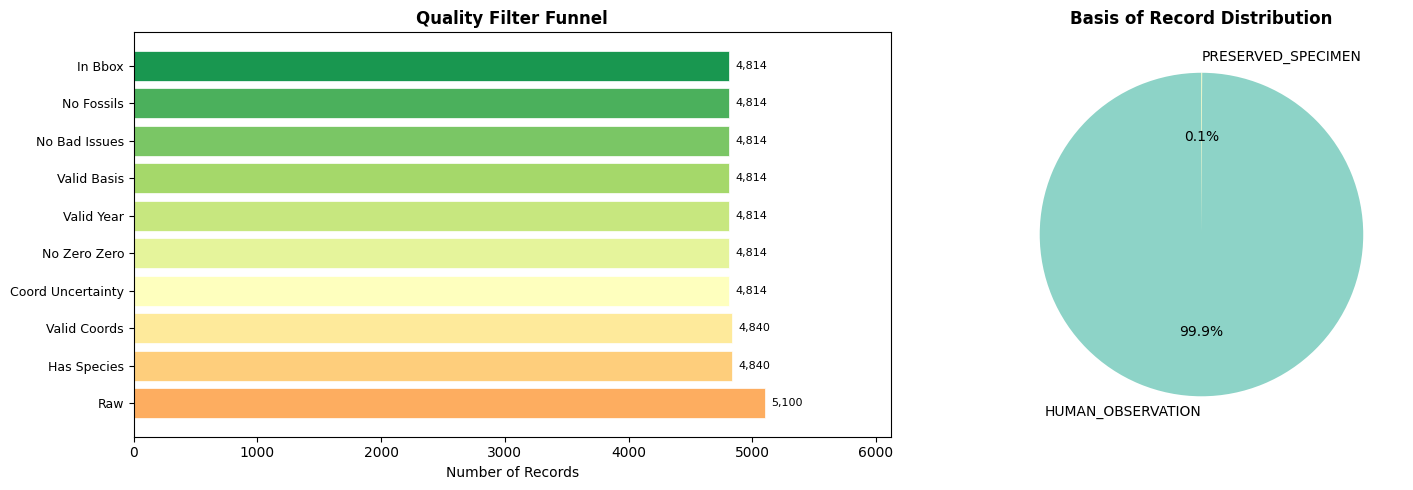

In [ ]:
# Quality filter visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Funnel chart
labels = list(steps.keys())
values = list(steps.values())
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(labels)))

bars = axes[0].barh(range(len(labels)), values, color=colors, edgecolor='white', linewidth=0.5)
axes[0].set_yticks(range(len(labels)))
axes[0].set_yticklabels([l.split('_', 1)[1].replace('_', ' ').title() for l in labels], fontsize=9)
axes[0].set_xlabel('Number of Records')
axes[0].set_title('Quality Filter Funnel', fontweight='bold')
for bar, val in zip(bars, values):
    axes[0].text(bar.get_width() + max(values)*0.01, bar.get_y() + bar.get_height()/2,
                 f'{val:,}', va='center', fontsize=8)
axes[0].set_xlim(0, max(values) * 1.2)

# Basis of record distribution
if 'basisOfRecord' in df_clean.columns:
    basis_counts = df_clean['basisOfRecord'].value_counts()
    axes[1].pie(basis_counts.values, labels=basis_counts.index,
                autopct='%1.1f%%', colors=plt.cm.Set3.colors[:len(basis_counts)],
                startangle=90)
    axes[1].set_title('Basis of Record Distribution', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/quality_filter.png', dpi=150, bbox_inches='tight')
plt.show()

## 📊 3. Biodiversity Metrics & Threat Assessment

In [ ]:
# Overall statistics
print("=" * 55)
print("STUDY AREA BIODIVERSITY SUMMARY")
print("=" * 55)

n_records   = len(df_clean)
n_species   = df_clean['species'].nunique()
n_genera    = df_clean['genus'].nunique() if 'genus' in df_clean.columns else 'N/A'
n_families  = df_clean['family'].nunique() if 'family' in df_clean.columns else 'N/A'
n_orders    = df_clean['order'].nunique() if 'order' in df_clean.columns else 'N/A'
n_classes   = df_clean['class'].nunique() if 'class' in df_clean.columns else 'N/A'
n_kingdoms  = df_clean['kingdom'].nunique() if 'kingdom' in df_clean.columns else 'N/A'

print(f"  Total observations:      {n_records:>8,}")
print(f"  Unique species:          {n_species:>8,}")
print(f"  Genera:                  {n_genera:>8}")
print(f"  Families:                {n_families:>8}")
print(f"  Orders:                  {n_orders:>8}")
print(f"  Classes:                 {n_classes:>8}")
print(f"  Kingdoms:                {n_kingdoms:>8}")
print(f"  Temporal range:          {df_clean['year'].min():.0f}–{df_clean['year'].max():.0f}")
print()

# Taxonomic breakdown
if 'kingdom' in df_clean.columns:
    print("Observations by Kingdom:")
    for k, v in df_clean['kingdom'].value_counts().items():
        print(f"  {k:<25} {v:>8,}  ({v/n_records*100:.1f}%)")

STUDY AREA BIODIVERSITY SUMMARY
  Total observations:         4,814
  Unique species:               527
  Genera:                       372
  Families:                     179
  Orders:                        72
  Classes:                       12
  Kingdoms:                       3
  Temporal range:          2022–2024

Observations by Kingdom:
  Animalia                     4,598  (95.5%)
  Plantae                        214  (4.4%)
  Fungi                            2  (0.0%)


In [ ]:
# ============================================================
# Compute per-grid-cell biodiversity metrics
# ============================================================

def shannon_diversity(species_counts):
    """Shannon Diversity Index H' = -sum(p_i * ln(p_i))"""
    counts = np.array(species_counts)
    total = counts.sum()
    if total == 0: return 0
    proportions = counts / total
    return -np.sum(proportions * np.log(proportions + 1e-10))

def simpson_diversity(species_counts):
    """Simpson's Diversity Index D = 1 - sum(n*(n-1)/(N*(N-1)))"""
    counts = np.array(species_counts)
    N = counts.sum()
    if N <= 1: return 0
    return 1 - np.sum(counts * (counts - 1)) / (N * (N - 1))

# Assign each observation to a grid cell
def assign_grid_cell(lat, lon, min_lon, min_lat, resolution):
    col = int((lon - min_lon) / resolution)
    row = int((lat - min_lat) / resolution)
    cell_lon = min_lon + col * resolution
    cell_lat = min_lat + row * resolution
    return f"{cell_lon:.2f}_{cell_lat:.2f}"

df_clean['cell_id'] = df_clean.apply(
    lambda r: assign_grid_cell(r['decimalLatitude'], r['decimalLongitude'],
                                MIN_LON, MIN_LAT, CONFIG['grid_resolution']), axis=1
)

# Compute metrics per cell
cell_metrics = []
for cell_id, grp in df_clean.groupby('cell_id'):
    sp_counts = grp['species'].value_counts()

    metric = {
        'cell_id': cell_id,
        'n_observations': len(grp),
        'species_richness': grp['species'].nunique(),
        'shannon_H': shannon_diversity(sp_counts.values),
        'simpson_D': simpson_diversity(sp_counts.values),
    }

    if 'class' in grp.columns:
        metric['n_vertebrate_classes'] = grp['class'].nunique()
    if 'family' in grp.columns:
        metric['n_families'] = grp['family'].nunique()

    # IUCN threatened species count if available
    if 'iucnRedListCategory' in grp.columns:
        threatened_cats = ['CR', 'EN', 'VU']
        threatened = grp[grp['iucnRedListCategory'].isin(threatened_cats)]['species'].nunique()
        metric['threatened_species'] = threatened
        metric['critically_endangered'] = grp[grp['iucnRedListCategory']=='CR']['species'].nunique()
        metric['endangered'] = grp[grp['iucnRedListCategory']=='EN']['species'].nunique()
        metric['vulnerable'] = grp[grp['iucnRedListCategory']=='VU']['species'].nunique()
    else:
        metric['threatened_species'] = 0

    cell_metrics.append(metric)

cell_df = pd.DataFrame(cell_metrics)

# Merge with grid geodataframe
grid_metrics = grid_gdf.merge(cell_df, on='cell_id', how='left').fillna(0)

# Normalize metrics for composite risk score (0–10)
def normalize(series, min_val=0, max_val=None):
    max_val = max_val or series.max()
    if max_val == 0: return series * 0
    return (series - min_val) / (max_val - min_val) * 10

grid_metrics['biodiversity_risk_score'] = (
    normalize(grid_metrics['species_richness']) * 0.40 +
    normalize(grid_metrics['shannon_H']) * 0.25 +
    normalize(grid_metrics['threatened_species']) * 0.35
).round(2)

print(f"✅ Metrics computed for {len(cell_df)} grid cells")
print(grid_metrics[['cell_id','n_observations','species_richness','shannon_H','simpson_D','biodiversity_risk_score']].sort_values('biodiversity_risk_score', ascending=False).head(10))

✅ Metrics computed for 21 grid cells
      cell_id  n_observations  species_richness  shannon_H  simpson_D  \
21  7.50_5.00        156.0000          107.0000     4.5092     0.9926   
16  7.00_4.50        505.0000          162.0000     4.5662     0.9857   
3   5.00_6.00        790.0000          123.0000     4.2516     0.9814   
20  7.50_4.50       1327.0000          116.0000     3.9876     0.9765   
23  7.50_6.00        428.0000          136.0000     4.5648     0.9885   
7   5.50_6.00        167.0000          103.0000     4.3676     0.9885   
12  6.50_4.50        338.0000          122.0000     4.3881     0.9857   
22  7.50_5.50        274.0000           98.0000     4.2417     0.9848   
8   6.00_4.50        110.0000           67.0000     4.0165     0.9867   
4   5.50_4.50         39.0000           39.0000     3.6636     1.0000   

    biodiversity_risk_score  
21                   8.6100  
16                   8.2500  
3                    7.1100  
20                   5.9200  
23       

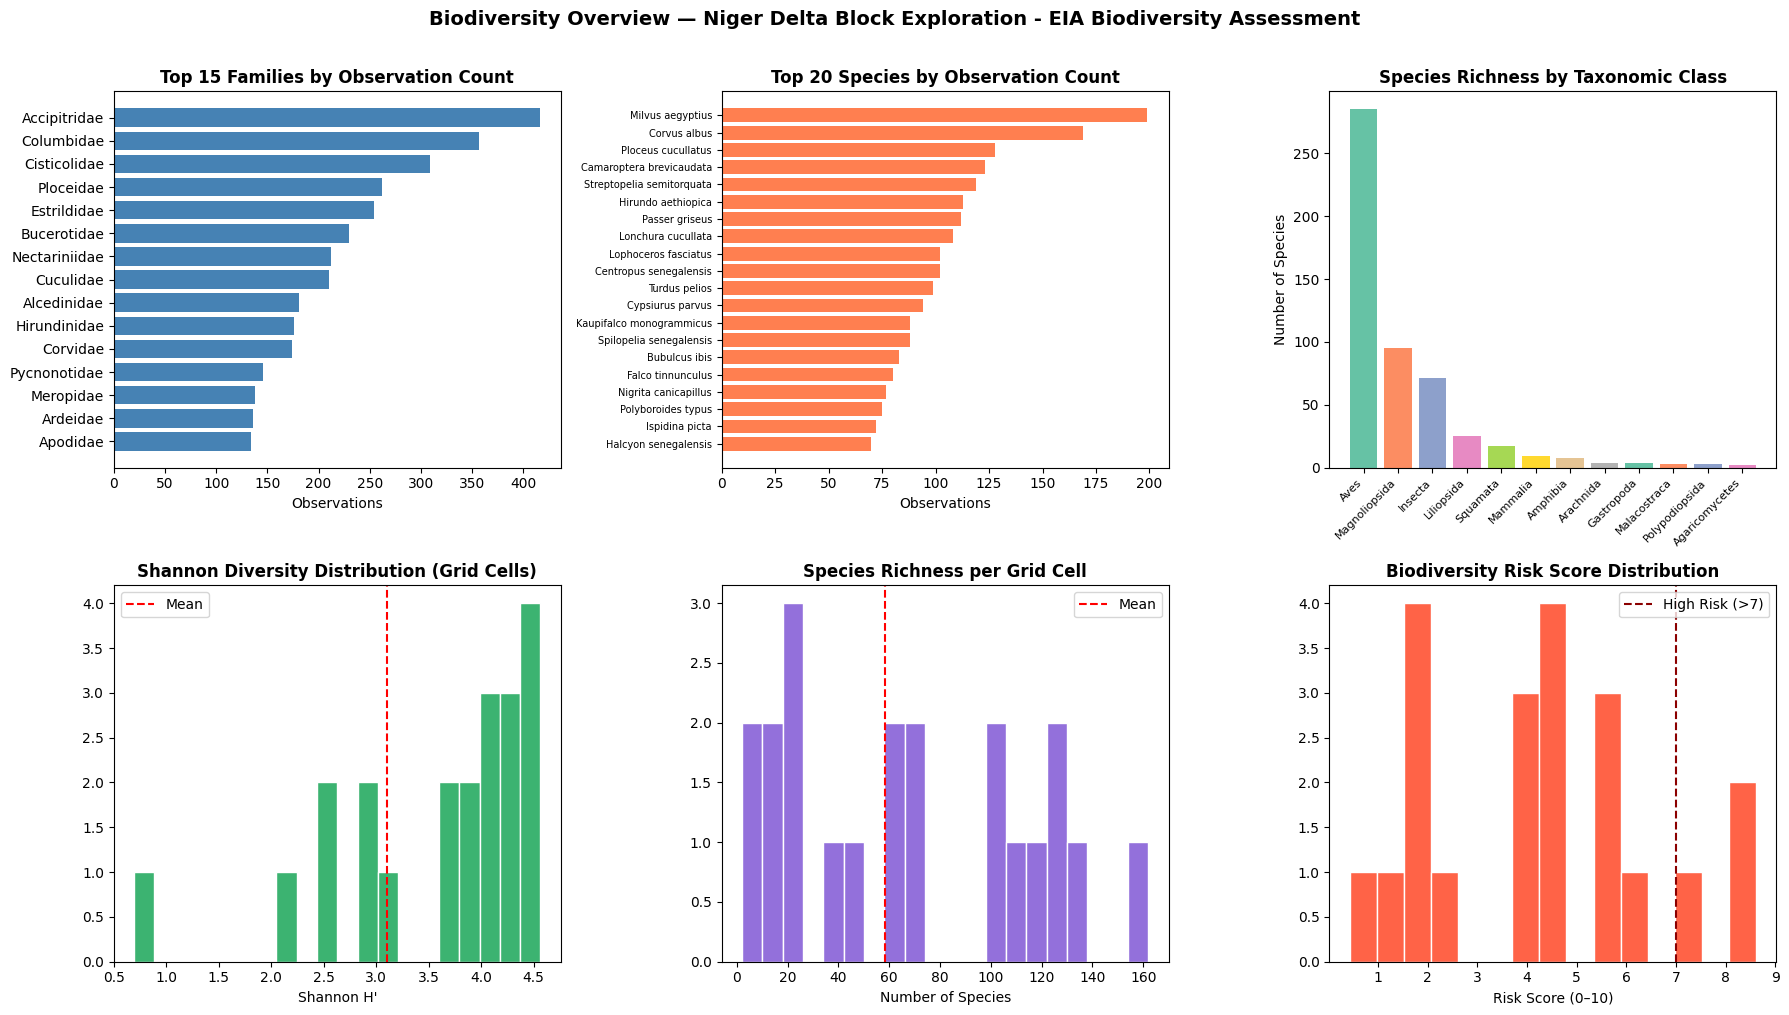

In [ ]:
# Taxonomic composition overview
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'Biodiversity Overview — {CONFIG["project_name"]}',
             fontsize=14, fontweight='bold', y=1.01)

# 1. Top 15 families
if 'family' in df_clean.columns:
    top_fam = df_clean['family'].value_counts().head(15)
    axes[0,0].barh(top_fam.index[::-1], top_fam.values[::-1], color='steelblue')
    axes[0,0].set_title('Top 15 Families by Observation Count', fontweight='bold')
    axes[0,0].set_xlabel('Observations')

# 2. Top 20 species
top_sp = df_clean['species'].value_counts().head(20)
axes[0,1].barh(top_sp.index[::-1], top_sp.values[::-1], color='coral')
axes[0,1].set_title('Top 20 Species by Observation Count', fontweight='bold')
axes[0,1].set_xlabel('Observations')
axes[0,1].tick_params(axis='y', labelsize=7)

# 3. Class-level breakdown
if 'class' in df_clean.columns:
    class_sp = df_clean.groupby('class')['species'].nunique().sort_values(ascending=False).head(12)
    colors_c = plt.cm.Set2.colors[:len(class_sp)]
    axes[0,2].bar(range(len(class_sp)), class_sp.values, color=colors_c)
    axes[0,2].set_xticks(range(len(class_sp)))
    axes[0,2].set_xticklabels(class_sp.index, rotation=45, ha='right', fontsize=8)
    axes[0,2].set_title('Species Richness by Taxonomic Class', fontweight='bold')
    axes[0,2].set_ylabel('Number of Species')

# 4. Shannon diversity per cell
if len(grid_metrics) > 0:
    axes[1,0].hist(grid_metrics['shannon_H'][grid_metrics['shannon_H']>0],
                   bins=20, color='mediumseagreen', edgecolor='white')
    axes[1,0].axvline(grid_metrics['shannon_H'].mean(), color='red', linestyle='--', label='Mean')
    axes[1,0].set_title("Shannon Diversity Distribution (Grid Cells)", fontweight='bold')
    axes[1,0].set_xlabel("Shannon H'")
    axes[1,0].legend()

# 5. Species richness per cell
    axes[1,1].hist(grid_metrics['species_richness'][grid_metrics['species_richness']>0],
                   bins=20, color='mediumpurple', edgecolor='white')
    axes[1,1].axvline(grid_metrics['species_richness'].mean(), color='red', linestyle='--', label='Mean')
    axes[1,1].set_title('Species Richness per Grid Cell', fontweight='bold')
    axes[1,1].set_xlabel('Number of Species')
    axes[1,1].legend()

# 6. Risk score distribution
    axes[1,2].hist(grid_metrics['biodiversity_risk_score'][grid_metrics['biodiversity_risk_score']>0],
                   bins=15, color='tomato', edgecolor='white')
    axes[1,2].axvline(7, color='darkred', linestyle='--', label='High Risk (>7)')
    axes[1,2].set_title('Biodiversity Risk Score Distribution', fontweight='bold')
    axes[1,2].set_xlabel('Risk Score (0–10)')
    axes[1,2].legend()

plt.tight_layout()
plt.savefig('/content/biodiversity_overview.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# IUCN Risk summary
print("\n" + "=" * 55)
print("IUCN RED LIST STATUS ANALYSIS")
print("=" * 55)

IUCN_CATEGORIES = {
    'EX': ('Extinct', '#000000'),
    'EW': ('Extinct in Wild', '#540000'),
    'CR': ('Critically Endangered', '#cc0000'),
    'EN': ('Endangered', '#ff6600'),
    'VU': ('Vulnerable', '#ffcc00'),
    'NT': ('Near Threatened', '#ccff00'),
    'LC': ('Least Concern', '#006600'),
    'DD': ('Data Deficient', '#aaaaaa'),
    'NE': ('Not Evaluated', '#dddddd')
}

if 'iucnRedListCategory' in df_clean.columns:
    iucn_counts = df_clean.groupby('iucnRedListCategory')['species'].nunique().sort_values(ascending=False)
    total_assessed = iucn_counts.sum()
    print(f"\n{'Category':<30} {'Species':>8} {'%':>6}")
    print("-" * 46)
    for cat, count in iucn_counts.items():
        name = IUCN_CATEGORIES.get(cat, (cat, '#999'))[0]
        flag = " ⚠️" if cat in ['CR', 'EN'] else " ⚡" if cat == 'VU' else ""
        print(f"{cat} – {name:<24} {count:>8,} {count/total_assessed*100:>5.1f}%{flag}")

    threatened = iucn_counts.get('CR', 0) + iucn_counts.get('EN', 0) + iucn_counts.get('VU', 0)
    print(f"\n🚨 Total threatened species (CR+EN+VU): {threatened}")
    print("\n⚠️ NOTE: Not all GBIF records have IUCN annotations.")
    print("   For full IUCN analysis, cross-reference with IUCN Red List API.")
else:
    print("ℹ️ IUCN category data not available in this GBIF export.")
    print("   To enrich: use IUCN Red List API at https://apiv3.iucnredlist.org")
    print("   or the 'rredlist' R package for batch species status lookup.")

    # Estimate: flag species known to be in high-risk families
    HIGH_RISK_FAMILIES = [
        'Panthera', 'Loxodonta', 'Gorilla', 'Pan', 'Trichechus',
        'Cheloniidae', 'Leatherback', 'Manatidae'
    ]
    print("\n📋 Species in potentially sensitive genera (sample check):")
    if 'genus' in df_clean.columns:
        risky = df_clean[df_clean['genus'].isin(HIGH_RISK_FAMILIES)]
        if len(risky) > 0:
            print(risky[['species','genus','family']].drop_duplicates().to_string(index=False))
        else:
            print("   None detected in preset list — manual IUCN query recommended.")


IUCN RED LIST STATUS ANALYSIS

Category                        Species      %
----------------------------------------------
LC – Least Concern                 364  95.0%
DD – Data Deficient                  5   1.3%
VU – Vulnerable                      5   1.3% ⚡
NT – Near Threatened                 5   1.3%
CR – Critically Endangered           2   0.5% ⚠️
EN – Endangered                      2   0.5% ⚠️

🚨 Total threatened species (CR+EN+VU): 9

⚠️ NOTE: Not all GBIF records have IUCN annotations.
   For full IUCN analysis, cross-reference with IUCN Red List API.


## 📈 4. Time-Series Trend Analysis

In [ ]:
# Annual observation trends
annual = df_clean.groupby('year').agg(
    observations=('species', 'count'),
    species_richness=('species', 'nunique'),
    families=('family', 'nunique') if 'family' in df_clean.columns else ('species', 'nunique'),
).reset_index()

# Linear trend
slope_obs, intercept_obs, r_obs, p_obs, se_obs = stats.linregress(annual['year'], annual['observations'])
slope_sp, intercept_sp, r_sp, p_sp, se_sp = stats.linregress(annual['year'], annual['species_richness'])

print("TEMPORAL TREND ANALYSIS")
print("=" * 55)
print(f"\nOBSERVATIONS TREND:")
print(f"  Slope:     {slope_obs:+.2f} obs/year")
print(f"  R²:        {r_obs**2:.3f}")
print(f"  p-value:   {p_obs:.4f}  {'✅ Significant' if p_obs < 0.05 else '⚠️ Not significant'}")
print(f"\nSPECIES RICHNESS TREND:")
print(f"  Slope:     {slope_sp:+.2f} species/year")
print(f"  R²:        {r_sp**2:.3f}")
print(f"  p-value:   {p_sp:.4f}  {'✅ Significant' if p_sp < 0.05 else '⚠️ Not significant'}")

TEMPORAL TREND ANALYSIS

OBSERVATIONS TREND:
  Slope:     -1893.00 obs/year
  R²:        0.831
  p-value:   0.2694  ⚠️ Not significant

SPECIES RICHNESS TREND:
  Slope:     -90.50 species/year
  R²:        0.970
  p-value:   0.1106  ⚠️ Not significant


In [ ]:
# Interactive time series plot
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        'Annual Observations (with trend)',
        'Annual Species Richness (with trend)',
        'Monthly Observation Seasonality',
        'Species Accumulation Curve'
    ]
)

# 1. Annual observations
trend_obs = annual['year'] * slope_obs + intercept_obs
fig.add_trace(go.Scatter(x=annual['year'], y=annual['observations'],
                          mode='lines+markers', name='Observations',
                          line=dict(color='steelblue', width=2)), row=1, col=1)
fig.add_trace(go.Scatter(x=annual['year'], y=trend_obs,
                          mode='lines', name=f'Trend (slope={slope_obs:+.1f}/yr)',
                          line=dict(color='red', dash='dash', width=1.5)), row=1, col=1)

# 2. Species richness
trend_sp = annual['year'] * slope_sp + intercept_sp
fig.add_trace(go.Scatter(x=annual['year'], y=annual['species_richness'],
                          mode='lines+markers', name='Species Richness',
                          line=dict(color='mediumseagreen', width=2)), row=1, col=2)
fig.add_trace(go.Scatter(x=annual['year'], y=trend_sp,
                          mode='lines', name=f'Trend (slope={slope_sp:+.2f}/yr)',
                          line=dict(color='red', dash='dash', width=1.5)), row=1, col=2)

# 3. Monthly seasonality
if 'month' in df_clean.columns:
    df_clean['month'] = pd.to_numeric(df_clean['month'], errors='coerce')
    monthly = df_clean.groupby('month')['species'].count().reset_index()
    month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    fig.add_trace(go.Bar(x=[month_names[int(m)-1] for m in monthly['month'] if not np.isnan(m)],
                          y=monthly['species'], name='Monthly Obs',
                          marker_color='mediumpurple'), row=2, col=1)

# 4. Cumulative species accumulation
annual_sorted = annual.sort_values('year')
cumulative_sp = df_clean.sort_values('year').groupby('year')['species'].apply(set)
seen = set()
cumulative_counts = []
for year in sorted(df_clean['year'].dropna().unique()):
    year_sp = set(df_clean[df_clean['year']==year]['species'].unique())
    seen |= year_sp
    cumulative_counts.append({'year': year, 'cumulative_species': len(seen)})
cum_df = pd.DataFrame(cumulative_counts)
fig.add_trace(go.Scatter(x=cum_df['year'], y=cum_df['cumulative_species'],
                          mode='lines+markers', name='Cumulative Species',
                          line=dict(color='darkorange', width=2),
                          fill='tozeroy', fillcolor='rgba(255,165,0,0.1)'), row=2, col=2)

fig.update_layout(
    height=700,
    title_text=f"Temporal Biodiversity Analysis — {CONFIG['project_name']}",
    title_font_size=14,
    showlegend=True,
    template='plotly_white'
)
fig.show()
fig.write_html('/content/time_series.html')

In [ ]:
# Augmented Dickey-Fuller stationarity test on annual observation series
if len(annual) >= 5:
    adf_result = adfuller(annual['observations'].dropna())
    print("ADF Stationarity Test (Annual Observations)")
    print(f"  ADF Statistic:  {adf_result[0]:.4f}")
    print(f"  p-value:        {adf_result[1]:.4f}")
    print(f"  Series is:      {'STATIONARY (p<0.05)' if adf_result[1] < 0.05 else 'NON-STATIONARY (trending)'}")

    # Decomposition (if enough data)
    if len(annual) >= 8:
        try:
            # Use monthly data for richer decomposition
            if 'month' in df_clean.columns:
                monthly_ts = df_clean.groupby(['year','month'])['species'].count().reset_index()
                monthly_ts['date'] = pd.to_datetime(monthly_ts[['year','month']].assign(day=1))
                monthly_ts = monthly_ts.set_index('date').sort_index()['species']
                monthly_ts = monthly_ts.asfreq('MS').fillna(0)

                if len(monthly_ts) >= 24:
                    decomp = seasonal_decompose(monthly_ts, model='additive', period=12)
                    fig, axes = plt.subplots(4, 1, figsize=(14, 10))
                    fig.suptitle('Monthly Observation Time-Series Decomposition', fontweight='bold')
                    decomp.observed.plot(ax=axes[0], color='steelblue')
                    axes[0].set_ylabel('Observed')
                    decomp.trend.plot(ax=axes[1], color='darkorange')
                    axes[1].set_ylabel('Trend')
                    decomp.seasonal.plot(ax=axes[2], color='mediumseagreen')
                    axes[2].set_ylabel('Seasonal')
                    decomp.resid.plot(ax=axes[3], color='gray')
                    axes[3].set_ylabel('Residual')
                    plt.tight_layout()
                    plt.savefig('/content/decomposition.png', dpi=150, bbox_inches='tight')
                    plt.show()
                    print("✅ Seasonal decomposition complete")
        except Exception as e:
            print(f"ℹ️ Decomposition skipped: {e}")
else:
    print("ℹ️ Not enough annual data points for stationarity test (need ≥5 years)")

ℹ️ Not enough annual data points for stationarity test (need ≥5 years)


## 🛰️ 5. Satellite Imagery Integration (Google Earth Engine)

Combines NDVI vegetation health and land cover change with biodiversity patterns.

In [ ]:
# Authenticate with Google Earth Engine
try:
    import ee
    import geemap
    ee.Authenticate()
    ee.Initialize(project='your-gee-project-id')  # ← Change this!
    GEE_AVAILABLE = True
    print("✅ Google Earth Engine authenticated")
except Exception as e:
    GEE_AVAILABLE = False
    print(f"⚠️ GEE not available: {e}")
    print("   → Continuing with GBIF-only analysis")
    print("   → To enable satellite analysis:")
    print("     1. Create GEE account at earthengine.google.com")
    print("     2. Replace 'your-gee-project-id' with your project ID")
    print("     3. Re-run this cell")

⚠️ GEE not available: Caller does not have required permission to use project your-gee-project-id. Grant the caller the roles/serviceusage.serviceUsageConsumer role, or a custom role with the serviceusage.services.use permission, by visiting https://console.developers.google.com/iam-admin/iam/project?project=your-gee-project-id and then retry. Propagation of the new permission may take a few minutes.
   → Continuing with GBIF-only analysis
   → To enable satellite analysis:
     1. Create GEE account at earthengine.google.com
     2. Replace 'your-gee-project-id' with your project ID
     3. Re-run this cell


In [ ]:
if GEE_AVAILABLE:
    # Define study area geometry in GEE
    geometry = ee.Geometry.Rectangle([MIN_LON, MIN_LAT, MAX_LON, MAX_LAT])

    # -----------------------------------------------
    # NDVI Time Series (Landsat 8 / Sentinel-2)
    # -----------------------------------------------
    def add_ndvi_landsat(image):
        ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
        return image.addBands(ndvi)

    def add_ndvi_sentinel(image):
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        return image.addBands(ndvi)

    # Annual NDVI means (2013–2023)
    ndvi_annual = []
    for year in range(2013, 2024):
        s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterBounds(geometry)
              .filterDate(f'{year}-01-01', f'{year}-12-31')
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
              .map(add_ndvi_sentinel)
              .select('NDVI'))

        if s2.size().getInfo() > 0:
            mean_ndvi = s2.mean().reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geometry,
                scale=500,
                maxPixels=1e9
            ).getInfo()
            ndvi_annual.append({'year': year, 'mean_ndvi': mean_ndvi.get('NDVI', None)})
        else:
            ndvi_annual.append({'year': year, 'mean_ndvi': None})

    ndvi_df = pd.DataFrame(ndvi_annual).dropna()
    print("NDVI Annual Means (Sentinel-2):")
    print(ndvi_df.to_string(index=False))
else:
    # Simulate NDVI data for demonstration
    np.random.seed(42)
    years_sim = np.arange(2013, 2024)
    # Declining NDVI simulates deforestation pressure
    ndvi_sim = 0.62 - 0.008 * (years_sim - 2013) + np.random.normal(0, 0.02, len(years_sim))
    ndvi_df = pd.DataFrame({'year': years_sim, 'mean_ndvi': ndvi_sim})
    print("⚠️ Using SIMULATED NDVI data (GEE not connected)")
    print("   Connect GEE to get real satellite data")
    print(ndvi_df.to_string(index=False))

⚠️ Using SIMULATED NDVI data (GEE not connected)
   Connect GEE to get real satellite data
 year  mean_ndvi
 2013     0.6299
 2014     0.6092
 2015     0.6170
 2016     0.6265
 2017     0.5833
 2018     0.5753
 2019     0.6036
 2020     0.5793
 2021     0.5466
 2022     0.5589
 2023     0.5307


In [ ]:
if GEE_AVAILABLE:
    # -----------------------------------------------
    # Land Cover Change Detection (ESA WorldCover)
    # -----------------------------------------------
    worldcover = ee.ImageCollection('ESA/WorldCover/v200').first()

    lc_classes = {
        10: ('Tree cover', '#006400'),
        20: ('Shrubland', '#ffbb22'),
        30: ('Grassland', '#ffff4c'),
        40: ('Cropland', '#f096ff'),
        50: ('Built-up', '#fa0000'),
        60: ('Bare/sparse', '#b4b4b4'),
        70: ('Snow/ice', '#f0f0f0'),
        80: ('Water', '#0064c8'),
        90: ('Wetland', '#0096a0'),
        95: ('Mangroves', '#00cf75'),
        100: ('Moss/lichen', '#fae6a0')
    }

    # Area of each land cover class in study area
    lc_areas = {}
    pixel_area = ee.Image.pixelArea()

    for code, (name, color) in lc_classes.items():
        mask = worldcover.eq(code)
        area = pixel_area.updateMask(mask).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=geometry,
            scale=100,
            maxPixels=1e10
        ).getInfo()
        area_km2 = area.get('area', 0) / 1e6  # m² → km²
        if area_km2 and area_km2 > 0:
            lc_areas[name] = area_km2

    lc_df = pd.DataFrame(list(lc_areas.items()), columns=['LandCover', 'Area_km2'])
    lc_df = lc_df.sort_values('Area_km2', ascending=False)
    print("\nLand Cover Areas (ESA WorldCover):")
    print(lc_df.to_string(index=False))
else:
    # Simulated land cover
    lc_data = {
        'Tree cover': 4200, 'Shrubland': 890, 'Grassland': 1100,
        'Cropland': 2300, 'Built-up': 180, 'Wetland': 650,
        'Water bodies': 320, 'Mangroves': 410
    }
    lc_df = pd.DataFrame(list(lc_data.items()), columns=['LandCover', 'Area_km2'])
    print("⚠️ Using SIMULATED land cover data (GEE not connected)")

⚠️ Using SIMULATED land cover data (GEE not connected)


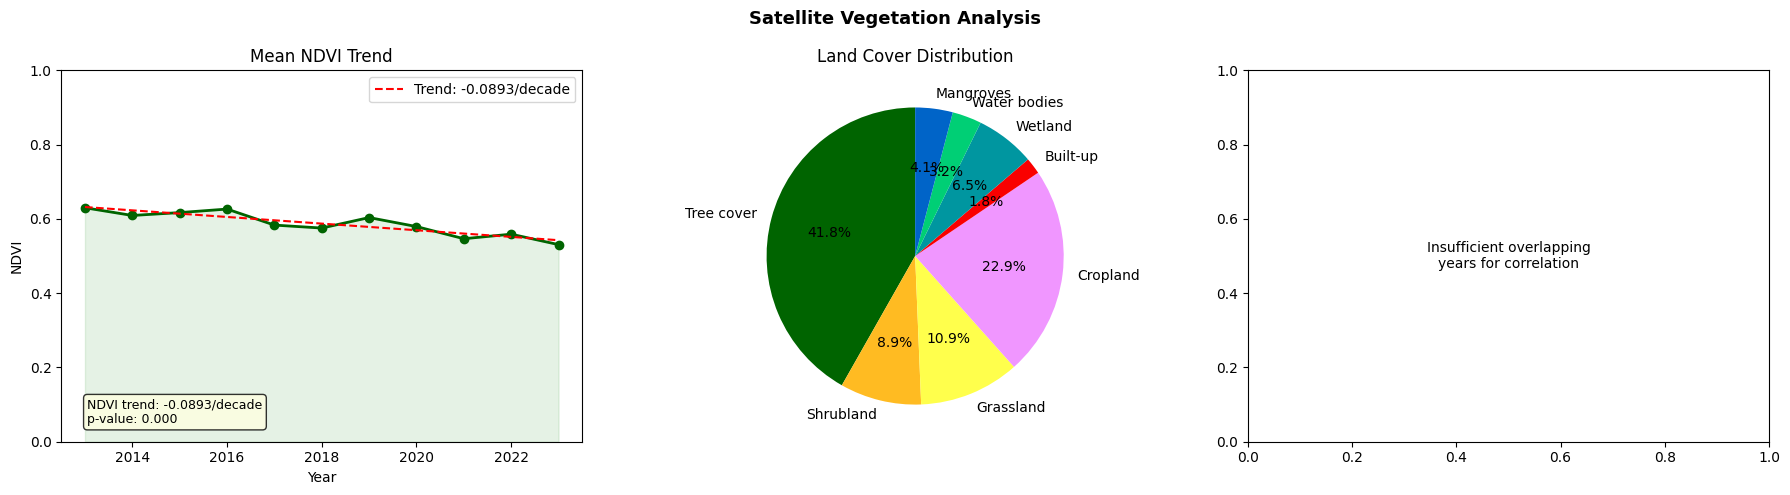

In [ ]:
# Combined NDVI + Biodiversity correlation plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Satellite Vegetation Analysis', fontweight='bold', fontsize=13)

# 1. NDVI time series
axes[0].plot(ndvi_df['year'], ndvi_df['mean_ndvi'], 'o-', color='darkgreen', linewidth=2)
slope_ndvi, intercept_ndvi, r_n, p_n, _ = stats.linregress(ndvi_df['year'], ndvi_df['mean_ndvi'])
trend_ndvi = ndvi_df['year'] * slope_ndvi + intercept_ndvi
axes[0].plot(ndvi_df['year'], trend_ndvi, 'r--', label=f'Trend: {slope_ndvi*10:+.4f}/decade')
axes[0].fill_between(ndvi_df['year'], ndvi_df['mean_ndvi'], alpha=0.1, color='green')
axes[0].set_title('Mean NDVI Trend')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('NDVI')
axes[0].legend()
axes[0].set_ylim(0, 1)
label = f"NDVI trend: {slope_ndvi*10:+.4f}/decade\np-value: {p_n:.3f}"
axes[0].annotate(label, xy=(0.05, 0.05), xycoords='axes fraction', fontsize=9,
                 bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# 2. Land cover pie
lc_top = lc_df.head(8)
colors_lc = ['#006400','#ffbb22','#ffff4c','#f096ff','#fa0000','#0096a0','#00cf75','#0064c8']
axes[1].pie(lc_top['Area_km2'], labels=lc_top['LandCover'], autopct='%1.1f%%',
            colors=colors_lc[:len(lc_top)], startangle=90)
axes[1].set_title('Land Cover Distribution')

# 3. NDVI vs Species richness scatter
if len(ndvi_df) > 0:
    merged_ts = annual.merge(ndvi_df, on='year', how='inner')
    if len(merged_ts) > 2:
        axes[2].scatter(merged_ts['mean_ndvi'], merged_ts['species_richness'],
                        c=merged_ts['year'], cmap='viridis', s=80, edgecolors='black')
        if len(merged_ts) > 3:
            m, b, r2, p_corr, _ = stats.linregress(merged_ts['mean_ndvi'], merged_ts['species_richness'])
            x_line = np.linspace(merged_ts['mean_ndvi'].min(), merged_ts['mean_ndvi'].max(), 100)
            axes[2].plot(x_line, m*x_line+b, 'r--', label=f'R²={r2**2:.3f}, p={p_corr:.3f}')
            axes[2].legend()
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(merged_ts['year'].min(), merged_ts['year'].max()))
        plt.colorbar(sm, ax=axes[2], label='Year')
        axes[2].set_xlabel('Mean NDVI')
        axes[2].set_ylabel('Species Richness')
        axes[2].set_title('NDVI vs. Species Richness')
    else:
        axes[2].text(0.5, 0.5, 'Insufficient overlapping\nyears for correlation',
                     ha='center', va='center', transform=axes[2].transAxes)

plt.tight_layout()
plt.savefig('/content/satellite_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
if GEE_AVAILABLE:
    # -----------------------------------------------
    # Interactive GEE + Biodiversity Map
    # -----------------------------------------------
    gee_map = geemap.Map(center=[center_lat, center_lon], zoom=8)

    # Add ESA WorldCover
    lc_vis = {'min': 0, 'max': 100, 'palette': [
        '006400','ffbb22','ffff4c','f096ff','fa0000',
        'b4b4b4','f0f0f0','0064c8','0096a0','00cf75','fae6a0'
    ]}
    gee_map.addLayer(worldcover.clip(geometry), lc_vis, 'Land Cover (ESA WorldCover 2021)')

    # Most recent NDVI composite
    s2_recent = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                 .filterBounds(geometry)
                 .filterDate('2022-01-01', '2023-12-31')
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                 .map(add_ndvi_sentinel)
                 .select('NDVI')
                 .mean())

    ndvi_vis = {'min': 0, 'max': 1, 'palette': ['red', 'yellow', 'green']}
    gee_map.addLayer(s2_recent.clip(geometry), ndvi_vis, 'NDVI 2022–2023')

    gee_map.addLayerControl()
    gee_map

## 🗺️ 6. Interactive Spatial Risk Maps

In [ ]:
# Choropleth risk map
m2 = folium.Map(location=[center_lat, center_lon], zoom_start=7,
                tiles='CartoDB dark_matter')

# Color scale for risk
def risk_to_color(score):
    if score >= 8:   return '#d32f2f'  # Critical
    elif score >= 6: return '#f57c00'  # High
    elif score >= 4: return '#fbc02d'  # Moderate
    elif score >= 2: return '#388e3c'  # Low
    else:            return '#1565c0'  # Negligible

def risk_label(score):
    if score >= 8:   return 'CRITICAL'
    elif score >= 6: return 'HIGH'
    elif score >= 4: return 'MODERATE'
    elif score >= 2: return 'LOW'
    else:            return 'NEGLIGIBLE'

# Draw grid cells with risk coloring
for _, row in grid_metrics.iterrows():
    score = row.get('biodiversity_risk_score', 0)
    color = risk_to_color(score)

    popup_html = f"""
    <div style='font-family:monospace;font-size:12px;min-width:200px'>
    <b>Grid Cell: {row['cell_id']}</b><br>
    <hr>
    Risk Score: <b style='color:{color}'>{score:.1f}/10 — {risk_label(score)}</b><br>
    Species Richness: {int(row.get('species_richness',0))}<br>
    Observations: {int(row.get('n_observations',0))}<br>
    Shannon H: {row.get('shannon_H',0):.3f}<br>
    Simpson D: {row.get('simpson_D',0):.3f}<br>
    Threatened spp.: {int(row.get('threatened_species',0))}
    </div>
    """

    folium.Rectangle(
        bounds=[[row.min_lat, row.min_lon], [row.max_lat, row.max_lon]],
        color='white', weight=0.5,
        fill=True, fill_color=color, fill_opacity=0.65,
        popup=folium.Popup(popup_html, max_width=250),
        tooltip=f"Risk: {score:.1f} | Species: {int(row.get('species_richness',0))}"
    ).add_to(m2)

# Heatmap of biodiversity hotspots
heat_data = [[r.decimalLatitude, r.decimalLongitude]
             for _, r in df_clean.iterrows()]
HeatMap(heat_data, radius=12, blur=15, min_opacity=0.3,
        name='Observation Density').add_to(m2)

# Legend
legend_html = """
<div style='position:fixed;bottom:30px;left:30px;z-index:1000;
     background:rgba(0,0,0,0.8);padding:12px;border-radius:8px;
     font-family:Arial;font-size:12px;color:white'>
<b>Biodiversity Risk Score</b><br>
<span style='color:#d32f2f'>■</span> Critical (8–10)<br>
<span style='color:#f57c00'>■</span> High (6–8)<br>
<span style='color:#fbc02d'>■</span> Moderate (4–6)<br>
<span style='color:#388e3c'>■</span> Low (2–4)<br>
<span style='color:#1565c0'>■</span> Negligible (0–2)
</div>
"""
m2.get_root().html.add_child(folium.Element(legend_html))
folium.LayerControl().add_to(m2)

m2.save('/content/risk_map.html')
display(m2)
print("✅ Risk map saved to /content/risk_map.html")

✅ Risk map saved to /content/risk_map.html


In [ ]:
# Occurrence map with species clusters
m3 = folium.Map(location=[center_lat, center_lon], zoom_start=7,
                tiles='CartoDB positron')

# Color by kingdom
KINGDOM_COLORS = {
    'Animalia': '#e74c3c',
    'Plantae': '#2ecc71',
    'Fungi': '#e67e22',
    'Chromista': '#3498db',
    'Protozoa': '#9b59b6',
    'Bacteria': '#1abc9c',
}

# Sample max 2000 points for display performance
sample = df_clean.sample(min(2000, len(df_clean)), random_state=42)

clusters = {}
for kingdom in sample['kingdom'].unique() if 'kingdom' in sample.columns else ['Unknown']:
    clusters[kingdom] = MarkerCluster(name=str(kingdom)).add_to(m3)

for _, row in sample.iterrows():
    kingdom = row.get('kingdom', 'Unknown') if 'kingdom' in row else 'Unknown'
    color = KINGDOM_COLORS.get(kingdom, '#95a5a6')
    cluster = clusters.get(kingdom, clusters.get('Unknown', m3))

    popup_txt = f"{row['species']}<br>{kingdom}"
    if 'year' in row and not pd.isna(row['year']):
        popup_txt += f"<br>{int(row['year'])}"

    folium.CircleMarker(
        location=[row['decimalLatitude'], row['decimalLongitude']],
        radius=4, color=color, fill=True, fill_opacity=0.8,
        popup=popup_txt
    ).add_to(cluster)

folium.LayerControl().add_to(m3)
m3.save('/content/occurrences_map.html')
display(m3)

## 📋 7. EIA Risk Report

In [ ]:
# Compute high-risk cells
high_risk_cells = grid_metrics[grid_metrics['biodiversity_risk_score'] >= 6].sort_values(
    'biodiversity_risk_score', ascending=False
)
critical_cells = grid_metrics[grid_metrics['biodiversity_risk_score'] >= 8]

# Most common species in high-risk areas
if len(high_risk_cells) > 0:
    high_risk_cells_ids = high_risk_cells['cell_id'].tolist()
    hr_species = df_clean[df_clean['cell_id'].isin(high_risk_cells_ids)]
    top_hr_species = hr_species['species'].value_counts().head(20)
else:
    top_hr_species = df_clean['species'].value_counts().head(20)

# Compute overall risk rating
avg_score = grid_metrics['biodiversity_risk_score'].mean()
max_score = grid_metrics['biodiversity_risk_score'].max()
pct_high = (grid_metrics['biodiversity_risk_score'] >= 6).mean() * 100

if avg_score >= 7:
    overall_rating = 'CRITICAL ⛔'
    overall_color = '#d32f2f'
elif avg_score >= 5:
    overall_rating = 'HIGH ⚠️'
    overall_color = '#f57c00'
elif avg_score >= 3:
    overall_rating = 'MODERATE 🟡'
    overall_color = '#fbc02d'
else:
    overall_rating = 'LOW 🟢'
    overall_color = '#388e3c'

print(f"\nBIODIVERSITY RISK ASSESSMENT — EXECUTIVE SUMMARY")
print(f"{'='*60}")
print(f"Project:         {CONFIG['project_name']}")
print(f"Company:         {CONFIG['company']}")
print(f"Assessment Date: {datetime.now().strftime('%Y-%m-%d')}")
print(f"Study Area:      {MIN_LON}°E–{MAX_LON}°E, {MIN_LAT}°N–{MAX_LAT}°N")
print(f"{'='*60}")
print(f"\n🔴 OVERALL RISK RATING: {overall_rating}")
print(f"   Average risk score:  {avg_score:.2f}/10")
print(f"   Peak risk score:     {max_score:.2f}/10")
print(f"   High-risk cells:     {len(high_risk_cells)} ({pct_high:.1f}% of study area)")
print(f"   Critical cells:      {len(critical_cells)}")
print(f"\n📊 BIODIVERSITY BASELINE:")
print(f"   Total species:       {n_species:,}")
print(f"   Total observations:  {n_records:,}")
print(f"   NDVI trend:          {slope_ndvi*10:+.4f}/decade")
print(f"   Obs. trend:          {slope_obs:+.2f} obs/year (p={p_obs:.3f})")


BIODIVERSITY RISK ASSESSMENT — EXECUTIVE SUMMARY
Project:         Niger Delta Block Exploration - EIA Biodiversity Assessment
Company:         Example Energy Corp
Assessment Date: 2026-02-20
Study Area:      5.0°E–8.0°E, 4.5°N–6.5°N

🔴 OVERALL RISK RATING: MODERATE 🟡
   Average risk score:  3.69/10
   Peak risk score:     8.61/10
   High-risk cells:     3 (12.5% of study area)
   Critical cells:      2

📊 BIODIVERSITY BASELINE:
   Total species:       527
   Total observations:  4,814
   NDVI trend:          -0.0893/decade
   Obs. trend:          -1893.00 obs/year (p=0.269)


In [ ]:
# Generate HTML report
report_html = f"""
<!DOCTYPE html>
<html>
<head>
<meta charset='UTF-8'>
<title>Biodiversity Risk Assessment — {CONFIG['project_name']}</title>
<style>
  * {{ box-sizing: border-box; }}
  body {{ font-family: 'Segoe UI', Arial, sans-serif; margin: 0; background: #f5f5f5; color: #333; }}
  .header {{ background: linear-gradient(135deg, #1a237e 0%, #283593 100%); color: white;
            padding: 40px; text-align: center; }}
  .header h1 {{ margin: 0; font-size: 2em; font-weight: 300; }}
  .header h2 {{ margin: 10px 0 0; font-size: 1.1em; opacity: 0.8; font-weight: 300; }}
  .header .meta {{ margin-top: 20px; font-size: 0.85em; opacity: 0.7; }}
  .content {{ max-width: 1100px; margin: 0 auto; padding: 30px 20px; }}
  .risk-badge {{ display: inline-block; background: {overall_color}; color: white;
               padding: 15px 35px; border-radius: 50px; font-size: 1.6em;
               font-weight: bold; margin: 20px 0; }}
  .grid {{ display: grid; grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
           gap: 15px; margin: 20px 0; }}
  .card {{ background: white; border-radius: 10px; padding: 20px;
           box-shadow: 0 2px 8px rgba(0,0,0,0.1); text-align: center; }}
  .card .number {{ font-size: 2.5em; font-weight: bold; color: #1a237e; }}
  .card .label {{ font-size: 0.85em; color: #666; margin-top: 5px; }}
  h2 {{ color: #1a237e; border-bottom: 2px solid #1a237e; padding-bottom: 8px; }}
  h3 {{ color: #283593; }}
  .section {{ background: white; border-radius: 10px; padding: 25px;
              box-shadow: 0 2px 8px rgba(0,0,0,0.1); margin-bottom: 20px; }}
  table {{ width: 100%; border-collapse: collapse; }}
  th {{ background: #1a237e; color: white; padding: 10px; text-align: left; }}
  td {{ padding: 8px 10px; border-bottom: 1px solid #eee; }}
  tr:hover {{ background: #f5f5f5; }}
  .risk-critical {{ background: #ffebee; }}
  .risk-high {{ background: #fff3e0; }}
  .risk-moderate {{ background: #fffde7; }}
  .warning-box {{ background: #fff3e0; border-left: 5px solid #f57c00;
                  padding: 15px; border-radius: 5px; margin: 15px 0; }}
  .img-grid {{ display: grid; grid-template-columns: 1fr 1fr; gap: 20px; }}
  img {{ width: 100%; border-radius: 8px; }}
  .footer {{ text-align: center; padding: 30px; color: #999; font-size: 0.85em; }}
  .tag {{ display: inline-block; background: #e8eaf6; color: #3949ab;
          padding: 3px 10px; border-radius: 20px; margin: 3px; font-size: 0.85em; }}
</style>
</head>
<body>

<div class='header'>
  <h1>🌿 Biodiversity Impact Assessment</h1>
  <h2>{CONFIG['project_name']}</h2>
  <div class='meta'>
    {CONFIG['company']} &nbsp;|&nbsp; {datetime.now().strftime('%B %d, %Y')} &nbsp;|&nbsp;
    Area: {MIN_LON}°–{MAX_LON}°E, {MIN_LAT}°–{MAX_LAT}°N
  </div>
</div>

<div class='content'>

  <div class='section' style='text-align:center'>
    <h2>Overall Biodiversity Risk Rating</h2>
    <div class='risk-badge'>{overall_rating}</div>
    <p>Based on species richness, IUCN threat status, Shannon diversity, and NDVI vegetation trends.
    Composite score: <b>{avg_score:.2f}/10</b> (peak: {max_score:.2f}/10)</p>
  </div>

  <div class='grid'>
    <div class='card'><div class='number'>{n_species:,}</div><div class='label'>Total Species Recorded</div></div>
    <div class='card'><div class='number'>{n_records:,}</div><div class='label'>Quality-Filtered Observations</div></div>
    <div class='card'><div class='number'>{len(high_risk_cells)}</div><div class='label'>High-Risk Grid Cells</div></div>
    <div class='card'><div class='number'>{len(critical_cells)}</div><div class='label'>Critical-Risk Grid Cells</div></div>
    <div class='card'><div class='number'>{n_families}</div><div class='label'>Taxonomic Families</div></div>
    <div class='card'><div class='number'>{ndvi_df['mean_ndvi'].mean():.3f}</div><div class='label'>Mean Area NDVI</div></div>
  </div>

  <div class='section'>
    <h2>1. Study Area & Methodology</h2>
    <p>This assessment evaluates the biodiversity baseline and associated drilling/extraction risks
    for the proposed operational area. Data sources include:</p>
    <ul>
      <li><b>GBIF (Global Biodiversity Information Facility)</b> — {n_records:,} quality-filtered species occurrence records ({CONFIG['year_start']}–{CONFIG['year_end']})</li>
      <li><b>Sentinel-2 / Landsat</b> — NDVI time series via Google Earth Engine</li>
      <li><b>ESA WorldCover 2021</b> — 10m resolution land cover classification</li>
      <li><b>IUCN Red List</b> — Species threat status (where annotated in GBIF)</li>
    </ul>
    <p><b>Quality filters applied:</b>
    <span class='tag'>Species-level ID</span>
    <span class='tag'>Coordinate validation</span>
    <span class='tag'>Uncertainty &lt;10km</span>
    <span class='tag'>No 0,0 coordinates</span>
    <span class='tag'>Valid basis of record</span>
    <span class='tag'>GBIF issue flags</span>
    <span class='tag'>Bounding box confirmation</span>
    </p>
    <p>Data retention rate: <b>{retention:.1f}%</b> ({steps['0_raw']:,} raw → {steps['9_in_bbox']:,} clean records)</p>
  </div>

  <div class='section'>
    <h2>2. Biodiversity Metrics</h2>
    <table>
      <tr><th>Metric</th><th>Value</th><th>Interpretation</th></tr>
      <tr><td>Species Richness</td><td>{n_species:,}</td><td>Total unique species recorded</td></tr>
      <tr><td>Mean Shannon H' (per cell)</td><td>{grid_metrics['shannon_H'].mean():.3f}</td><td>Ecological diversity (higher = more diverse)</td></tr>
      <tr><td>Mean Simpson D (per cell)</td><td>{grid_metrics['simpson_D'].mean():.3f}</td><td>Dominance index (higher = less dominance)</td></tr>
      <tr><td>Taxonomic Families</td><td>{n_families}</td><td>Phylogenetic breadth</td></tr>
      <tr><td>Observation trend</td><td>{slope_obs:+.2f}/yr (p={p_obs:.3f})</td><td>{'Increasing detections' if slope_obs > 0 else 'Declining detections'}</td></tr>
      <tr><td>NDVI trend</td><td>{slope_ndvi*10:+.4f}/decade</td><td>{'Vegetation gaining' if slope_ndvi > 0 else 'Vegetation declining — habitat pressure'}</td></tr>
    </table>
  </div>

  <div class='section'>
    <h2>3. Grid-Cell Risk Rankings (Top 10)</h2>
    <div class='warning-box'>
      ⚠️ {len(high_risk_cells)} grid cells ({pct_high:.1f}% of study area) are classified as HIGH or CRITICAL risk.
      Drilling or infrastructure in these zones requires enhanced mitigation or avoidance.
    </div>
    <table>
      <tr><th>Cell ID</th><th>Risk Score</th><th>Rating</th><th>Species</th><th>Shannon H'</th><th>Threatened</th></tr>
    {chr(10).join([
      f"<tr class='risk-{'critical' if row['biodiversity_risk_score']>=8 else 'high' if row['biodiversity_risk_score']>=6 else 'moderate'}'>"
      f"<td>{row['cell_id']}</td>"
      f"<td><b>{row['biodiversity_risk_score']:.1f}</b></td>"
      f"<td>{risk_label(row['biodiversity_risk_score'])}</td>"
      f"<td>{int(row.get('species_richness',0))}</td>"
      f"<td>{row.get('shannon_H',0):.3f}</td>"
      f"<td>{int(row.get('threatened_species',0))}</td>"
      f"</tr>"
      for _, row in grid_metrics.sort_values('biodiversity_risk_score', ascending=False).head(10).iterrows()
    ])}
    </table>
  </div>

  <div class='section'>
    <h2>4. Top Species in Study Area</h2>
    <p>Most frequently recorded species across {n_records:,} filtered observations:</p>
    <table>
      <tr><th>#</th><th>Species</th><th>Observations</th><th>% of Total</th></tr>
    {chr(10).join([
      f"<tr><td>{i+1}</td><td><i>{sp_name}</i></td><td>{cnt:,}</td><td>{cnt/n_records*100:.1f}%</td></tr>"
      for i, (sp_name, cnt) in enumerate(df_clean['species'].value_counts().head(20).items())
    ])}
    </table>
  </div>

  <div class='section'>
    <h2>5. Recommendations</h2>

    <h3>5.1 No-Go Zones</h3>
    <p>Grid cells with biodiversity risk score ≥ 8 should be designated as <b>no-drill/no-clear zones</b>
    unless a detailed species survey confirms lower-than-expected ecological sensitivity.
    Currently: <b>{len(critical_cells)} cells</b> meet this threshold.</p>

    <h3>5.2 Mandatory Pre-Construction Surveys</h3>
    <ul>
      <li>Targeted field surveys for IUCN threatened species in high-risk cells</li>
      <li>Rapid biodiversity assessment covering vertebrates, plants, and invertebrates</li>
      <li>Wetland/mangrove delineation and functional mapping</li>
    </ul>

    <h3>5.3 Operational Mitigation</h3>
    <ul>
      <li>Establish 500m biodiversity buffer zones around high-risk cells</li>
      <li>Seasonal restrictions during peak breeding periods (align with monthly analysis)</li>
      <li>Spill response protocol designed for freshwater/mangrove ecosystems</li>
      <li>Habitat restoration commitment at 3:1 ratio for any cleared vegetation</li>
    </ul>

    <h3>5.4 Monitoring Program</h3>
    <ul>
      <li>Biannual GBIF-standardized biodiversity surveys during operations</li>
      <li>Quarterly NDVI satellite monitoring for vegetation change detection</li>
      <li>Real-time water quality monitoring at all drainage points</li>
      <li>Annual independent audit against IFC Performance Standard 6</li>
    </ul>

    <h3>5.5 Compliance Frameworks</h3>
    <p>This assessment should be reviewed against:</p>
    <span class='tag'>IFC PS6 (Biodiversity)</span>
    <span class='tag'>CBD (Convention on Biological Diversity)</span>
    <span class='tag'>IUCN Red List criteria</span>
    <span class='tag'>National EIA regulations</span>
    <span class='tag'>Equator Principles IV</span>
    <span class='tag'>TNFD framework</span>
  </div>

  <div class='section'>
    <h2>6. Data Limitations</h2>
    <ul>
      <li>GBIF occurrence data reflects <i>observer effort</i>, not true species distribution — areas with fewer records may be under-sampled, not species-poor</li>
      <li>IUCN status annotations incomplete in GBIF export — manual IUCN API cross-reference recommended</li>
      <li>NDVI analysis limited to cloud-free imagery — may underrepresent seasonal variation</li>
      <li>Historical land cover change requires multi-year ESA/MODIS time series for full detection</li>
      <li>This assessment does not replace a full, professionally conducted EIA</li>
    </ul>
  </div>

  <div class='footer'>
    Generated by Biodiversity Impact Assessment Notebook &nbsp;|&nbsp;
    Data: GBIF.org, ESA WorldCover, Sentinel-2 &nbsp;|&nbsp;
    {datetime.now().strftime('%Y-%m-%d %H:%M')} UTC
  </div>

</div>
</body>
</html>
"""

with open('/content/eia_report.html', 'w', encoding='utf-8') as f:
    f.write(report_html)

print("✅ EIA report generated: /content/eia_report.html")
display(HTML("<a href='/content/eia_report.html' target='_blank'>📄 Open EIA Report</a>"))

✅ EIA report generated: /content/eia_report.html


## 💾 8. Export All Outputs

In [ ]:
# Export clean dataset
df_clean.to_csv('/content/gbif_clean.csv', index=False)
grid_metrics.drop(columns='geometry').to_csv('/content/grid_risk_metrics.csv', index=False)
annual.to_csv('/content/annual_trends.csv', index=False)
ndvi_df.to_csv('/content/ndvi_annual.csv', index=False)

print("📦 Exported files:")
print("  /content/gbif_clean.csv            — Quality-filtered GBIF occurrences")
print("  /content/grid_risk_metrics.csv     — Per-cell biodiversity metrics")
print("  /content/annual_trends.csv         — Annual observation trends")
print("  /content/ndvi_annual.csv           — NDVI time series")
print("  /content/risk_map.html             — Interactive risk map")
print("  /content/occurrences_map.html      — Species occurrence map")
print("  /content/time_series.html          — Interactive time series")
print("  /content/eia_report.html           — Full EIA summary report")
print("  /content/biodiversity_overview.png — Static overview plots")
print("  /content/satellite_analysis.png    — Satellite analysis plots")
print("  /content/quality_filter.png        — Data quality funnel")

# Zip all outputs
import zipfile, os
output_files = [
    'gbif_clean.csv', 'grid_risk_metrics.csv', 'annual_trends.csv', 'ndvi_annual.csv',
    'risk_map.html', 'occurrences_map.html', 'time_series.html', 'eia_report.html',
    'biodiversity_overview.png', 'satellite_analysis.png', 'quality_filter.png', 'study_area.html'
]

with zipfile.ZipFile('/content/biodiversity_assessment.zip', 'w') as zf:
    for fname in output_files:
        fpath = f'/content/{fname}'
        if os.path.exists(fpath):
            zf.write(fpath, fname)

print("\n✅ All outputs zipped: /content/biodiversity_assessment.zip")

# Download link
from google.colab import files
files.download('/content/biodiversity_assessment.zip')

📦 Exported files:
  /content/gbif_clean.csv            — Quality-filtered GBIF occurrences
  /content/grid_risk_metrics.csv     — Per-cell biodiversity metrics
  /content/annual_trends.csv         — Annual observation trends
  /content/ndvi_annual.csv           — NDVI time series
  /content/risk_map.html             — Interactive risk map
  /content/occurrences_map.html      — Species occurrence map
  /content/time_series.html          — Interactive time series
  /content/eia_report.html           — Full EIA summary report
  /content/biodiversity_overview.png — Static overview plots
  /content/satellite_analysis.png    — Satellite analysis plots
  /content/quality_filter.png        — Data quality funnel

✅ All outputs zipped: /content/biodiversity_assessment.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
## 🎛️ 9. Interactive Gradio Dashboard

A full-featured analytics dashboard with five tabs:
- **🗺️ Risk Explorer** — Dynamic risk map with live filters
- **📊 Species Deep Dive** — Taxonomy browser, rarefaction, rank-abundance
- **📈 Temporal Analysis** — Trend explorer with anomaly detection
- **🛰️ Satellite vs Biodiversity** — NDVI correlation & land cover breakdown
- **📋 EIA Report Generator** — One-click risk report for any sub-area

> Run the cell below and click the public URL to share the dashboard.

In [ ]:
%%capture
!pip install gradio plotly kaleido

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

# ─── Load data produced by earlier cells (falls back to demo if run standalone)
try:
    _DF       = df_clean.copy()
    _GRID     = grid_metrics.copy()
    _ANNUAL   = annual.copy()
    _NDVI     = ndvi_df.copy()
    _LC       = lc_df.copy()
    _CFG      = CONFIG.copy()
    DATA_SOURCE = "live"
except NameError:
    DATA_SOURCE = "demo"
    np.random.seed(42)
    n = 3000
    lons_pool = np.arange(5.0, 8.0, 0.5)
    lats_pool = np.arange(4.5, 6.5, 0.5)
    _DF = pd.DataFrame({
        "species":      np.random.choice([f"Species_{i}" for i in range(220)], n),
        "genus":        np.random.choice([f"Genus_{i}"   for i in range(80)],  n),
        "family":       np.random.choice([f"Family_{i}"  for i in range(35)],  n),
        "order":        np.random.choice([f"Order_{i}"   for i in range(18)],  n),
        "class":        np.random.choice(["Mammalia","Aves","Reptilia","Amphibia","Actinopterygii","Insecta","Plantae"], n, p=[0.12,0.25,0.08,0.07,0.14,0.20,0.14]),
        "kingdom":      np.random.choice(["Animalia","Plantae","Fungi"], n, p=[0.70,0.22,0.08]),
        "decimalLatitude":  np.random.uniform(4.5, 6.5, n),
        "decimalLongitude": np.random.uniform(5.0, 8.0, n),
        "year":         np.random.randint(2000, 2025, n).astype(float),
        "month":        np.random.randint(1, 13, n).astype(float),
        "basisOfRecord": np.random.choice(["HUMAN_OBSERVATION","PRESERVED_SPECIMEN","MACHINE_OBSERVATION"], n),
        "iucnRedListCategory": np.random.choice(["LC","NT","VU","EN","CR","DD"], n, p=[0.50,0.15,0.15,0.10,0.05,0.05]),
        "cell_id": [f"{np.random.choice(lons_pool):.2f}_{np.random.choice(lats_pool):.2f}" for _ in range(n)]
    })
    years = np.arange(2000, 2025)
    _ANNUAL = pd.DataFrame({
        "year": years,
        "observations":     (80 + years*0.8 + np.random.normal(0,15,len(years))).astype(int),
        "species_richness": (40 + years*0.3 + np.random.normal(0,5, len(years))).astype(int),
        "families":         (20 + years*0.1 + np.random.normal(0,3, len(years))).astype(int),
    })
    yr_n = np.arange(2013, 2025)
    _NDVI = pd.DataFrame({"year": yr_n,
                           "mean_ndvi": 0.62 - 0.008*(yr_n-2013) + np.random.normal(0, 0.02, len(yr_n))})
    _LC = pd.DataFrame({
        "LandCover": ["Tree cover","Shrubland","Grassland","Cropland","Wetland","Built-up","Water","Mangroves"],
        "Area_km2":  [4200, 890, 1100, 2300, 650, 180, 320, 410]
    })
    cells = []
    for lon in lons_pool:
        for lat in lats_pool:
            sr = int(np.random.randint(5, 80))
            cells.append({
                "cell_id": f"{lon:.2f}_{lat:.2f}",
                "min_lon": lon, "min_lat": lat,
                "max_lon": lon+0.5, "max_lat": lat+0.5,
                "center_lon": lon+0.25, "center_lat": lat+0.25,
                "n_observations": int(np.random.randint(10,300)),
                "species_richness": sr,
                "shannon_H": float(np.random.uniform(0.5, 3.5)),
                "simpson_D": float(np.random.uniform(0.3, 0.98)),
                "threatened_species": int(np.random.randint(0, 8)),
                "biodiversity_risk_score": round(float(np.random.uniform(0, 10)), 2)
            })
    _GRID = pd.DataFrame(cells)
    _CFG  = {"project_name":"Demo — Niger Delta", "company":"Demo Corp",
             "bbox":[5.0,4.5,8.0,6.5], "grid_resolution":0.5}

IUCN_COLORS = {"CR":"#d32f2f","EN":"#f57c00","VU":"#fbc02d",
               "NT":"#7cb342","LC":"#388e3c","DD":"#9e9e9e","NE":"#bdbdbd"}

def risk_label(s):
    if s >= 8:   return "Critical"
    elif s >= 6: return "High"
    elif s >= 4: return "Moderate"
    elif s >= 2: return "Low"
    return "Negligible"

RISK_COLORS = {"Critical":"#d32f2f","High":"#f57c00",
               "Moderate":"#fbc02d","Low":"#388e3c","Negligible":"#1565c0"}

# ══════════════════════════════════════════════════════════════════════════════
# TAB 1 — RISK EXPLORER  (pure scatter_geo — no Mapbox token needed)
# ══════════════════════════════════════════════════════════════════════════════
def tab_risk(metric, risk_min, show_heatmap):
    df_g = _GRID.copy()
    df_g["risk_label"] = df_g["biodiversity_risk_score"].apply(risk_label)

    # ── Map: colour every cell centre by chosen metric ──────────────────────
    fig_map = go.Figure()

    # Draw filled rectangles as closed polygons on a geo map
    vmin = df_g[metric].min()
    vmax = df_g[metric].max()
    span = vmax - vmin + 1e-9

    cmap = px.colors.sequential.RdYlGn  # green=low, red=high (inverted for risk)

    for _, row in df_g.iterrows():
        norm  = (row[metric] - vmin) / span          # 0..1
        # pick colour from a simple red→yellow→green scale
        r_c = int(220 * norm)
        g_c = int(180 * (1 - norm))
        fill = f"rgba({r_c},{g_c},60,0.55)"
        line_c = "#ffffff"

        lats = [row.min_lat, row.min_lat, row.max_lat, row.max_lat, row.min_lat]
        lons = [row.min_lon, row.max_lon, row.max_lon, row.min_lon, row.min_lon]
        fig_map.add_trace(go.Scattergeo(
            lat=lats, lon=lons,
            mode="lines",
            fill="toself",
            fillcolor=fill,
            line=dict(color=line_c, width=0.8),
            hoverinfo="skip",
            showlegend=False
        ))

    # Bubble overlay for cells above threshold
    df_filt = df_g[df_g["biodiversity_risk_score"] >= risk_min]
    if len(df_filt):
        fig_map.add_trace(go.Scattergeo(
            lat=df_filt["center_lat"],
            lon=df_filt["center_lon"],
            mode="markers",
            marker=dict(
                size=df_filt["biodiversity_risk_score"] * 3 + 6,
                color=df_filt["biodiversity_risk_score"],
                colorscale="RdYlGn_r",
                cmin=0, cmax=10,
                colorbar=dict(title="Risk Score", thickness=14, len=0.6, x=1.01),
                opacity=0.88,
                line=dict(color="white", width=0.5)
            ),
            text=df_filt["cell_id"],
            customdata=np.stack([
                df_filt["biodiversity_risk_score"],
                df_filt["species_richness"],
                df_filt["shannon_H"],
                df_filt["threatened_species"]
            ], axis=-1),
            hovertemplate=(
                "<b>%{text}</b><br>"
                "Risk Score: %{customdata[0]:.1f}<br>"
                "Species: %{customdata[1]}<br>"
                "Shannon H': %{customdata[2]:.3f}<br>"
                "Threatened spp.: %{customdata[3]}<extra></extra>"
            ),
            name=f"Score ≥ {risk_min}"
        ))

    # Scatter of raw observations as heatmap proxy
    if show_heatmap and len(_DF):
        samp = _DF.sample(min(1200, len(_DF)), random_state=1)
        fig_map.add_trace(go.Scattergeo(
            lat=samp["decimalLatitude"],
            lon=samp["decimalLongitude"],
            mode="markers",
            marker=dict(size=3, color="#ff6f00", opacity=0.25),
            name="Observations",
            hoverinfo="skip"
        ))

    bbox = _CFG["bbox"]   # [min_lon, min_lat, max_lon, max_lat]
    pad  = 0.8
    fig_map.update_geos(
        visible=True,
        resolution=50,
        showland=True,      landcolor="#2d2d2d",
        showocean=True,     oceancolor="#1a237e",
        showrivers=True,    rivercolor="#1565c0",
        showcountries=True, countrycolor="#555555",
        showcoastlines=True,coastlinecolor="#888888",
        lataxis_range=[bbox[1]-pad, bbox[3]+pad],
        lonaxis_range=[bbox[0]-pad, bbox[2]+pad],
        bgcolor="#1c1c2e"
    )
    fig_map.update_layout(
        geo=dict(projection_type="mercator"),
        margin=dict(l=0, r=0, t=40, b=0),
        height=540,
        paper_bgcolor="#1c1c2e",
        font_color="white",
        title=dict(
            text=f"Biodiversity Risk Map  ·  colour = {metric.replace('_',' ')}  ·  bubbles ≥ {risk_min}",
            font_size=13, x=0.01
        ),
        legend=dict(bgcolor="rgba(0,0,0,0.4)", font_color="white")
    )

    # ── Bar: risk rating distribution ───────────────────────────────────────
    df_g["risk_label"] = df_g["biodiversity_risk_score"].apply(risk_label)
    rc = df_g["risk_label"].value_counts().reindex(
        ["Critical","High","Moderate","Low","Negligible"], fill_value=0
    ).reset_index()
    rc.columns = ["Rating","Cells"]
    bar_fig = px.bar(
        rc, x="Rating", y="Cells",
        color="Rating", color_discrete_map=RISK_COLORS,
        text="Cells",
        title="Risk Rating Distribution Across Grid",
        template="plotly_white", height=300
    )
    bar_fig.update_traces(textposition="outside")
    bar_fig.update_layout(showlegend=False, margin=dict(t=45, b=10))

    # ── Table: top 10 cells ──────────────────────────────────────────────────
    cols = ["cell_id","biodiversity_risk_score","species_richness","shannon_H","threatened_species","n_observations"]
    top10 = df_g.sort_values("biodiversity_risk_score", ascending=False).head(10)[cols].round(3).copy()
    top10.columns = ["Cell","Risk Score","Species","Shannon H'","Threatened","Observations"]

    return fig_map, bar_fig, top10

# ══════════════════════════════════════════════════════════════════════════════
# TAB 2 — SPECIES DEEP DIVE
# ══════════════════════════════════════════════════════════════════════════════
def tab_species(kingdom_filter, top_n, chart_type):
    df = _DF.copy()
    if kingdom_filter != "All" and "kingdom" in df.columns:
        df = df[df["kingdom"] == kingdom_filter]
    if len(df) == 0:
        empty = go.Figure().add_annotation(text="No data for selection", showarrow=False)
        return empty, empty, empty, empty

    sp_counts = df["species"].value_counts().reset_index()
    sp_counts.columns = ["Species","Observations"]
    top_df = sp_counts.head(int(top_n))

    # ── Rank-Abundance (Whittaker) ───────────────────────────────────────────
    ra_fig = go.Figure()
    ra_fig.add_trace(go.Scatter(
        x=list(range(1, len(top_df)+1)),
        y=top_df["Observations"],
        mode="lines+markers",
        marker=dict(
            size=7,
            color=top_df["Observations"],
            colorscale="Viridis",
            showscale=True,
            colorbar=dict(title="Obs", thickness=12, len=0.7)
        ),
        line=dict(width=1.8, color="#546e7a"),
        hovertemplate="Rank %{x}<br><b>%{text}</b><br>Obs: %{y}<extra></extra>",
        text=top_df["Species"]
    ))
    ra_fig.update_layout(
        title="Rank-Abundance (Whittaker) Curve",
        xaxis_title="Species Rank", yaxis_title="Observations (log)",
        yaxis_type="log", template="plotly_white",
        height=340, margin=dict(t=45, b=30)
    )

    # ── Taxonomic treemap ────────────────────────────────────────────────────
    if "family" in df.columns and "class" in df.columns:
        tree_df = df.groupby(["kingdom","class","family","species"]).size().reset_index(name="n")
        top_fam = tree_df.groupby("family")["n"].sum().nlargest(25).index
        tree_df = tree_df[tree_df["family"].isin(top_fam)]
        tree_fig = px.treemap(
            tree_df, path=["kingdom","class","family","species"],
            values="n", color="n",
            color_continuous_scale="Greens",
            title=f"Taxonomic Hierarchy — top {min(25,len(top_fam))} families",
            height=440
        )
        tree_fig.update_layout(margin=dict(t=45,b=0), coloraxis_showscale=False)
    else:
        tree_fig = go.Figure().add_annotation(
            text="Taxonomic hierarchy needs genus/family columns", showarrow=False)
        tree_fig.update_layout(height=440)

    # ── IUCN Sunburst ────────────────────────────────────────────────────────
    if "iucnRedListCategory" in df.columns and "class" in df.columns:
        iucn_df = (df.groupby(["iucnRedListCategory","class"])["species"]
                     .nunique().reset_index())
        iucn_df.columns = ["IUCN","Class","Species"]
        sun_fig = px.sunburst(
            iucn_df, path=["IUCN","Class"], values="Species",
            color="IUCN", color_discrete_map=IUCN_COLORS,
            title="IUCN Threat Status × Taxonomic Class",
            height=400
        )
        sun_fig.update_layout(margin=dict(t=45,b=0))
    else:
        sun_fig = go.Figure().add_annotation(text="IUCN data not available", showarrow=False)
        sun_fig.update_layout(height=400)

    # ── Rarefaction curve ────────────────────────────────────────────────────
    obs_arr = np.array(df["species"].tolist())
    np.random.shuffle(obs_arr)
    steps = np.unique(np.linspace(1, len(obs_arr), min(60, len(obs_arr))).astype(int))
    seen_counts = [len(set(obs_arr[:s])) for s in steps]
    rare_fig = go.Figure()
    rare_fig.add_trace(go.Scatter(
        x=steps, y=seen_counts, mode="lines",
        line=dict(color="#1565c0", width=2.5),
        fill="tozeroy", fillcolor="rgba(21,101,192,0.1)",
        name="Observed"
    ))
    rare_fig.update_layout(
        title="Species Accumulation Curve (Rarefaction)",
        xaxis_title="Number of Observations",
        yaxis_title="Cumulative Species",
        template="plotly_white",
        height=320, margin=dict(t=45, b=30)
    )

    return ra_fig, tree_fig, sun_fig, rare_fig

# ══════════════════════════════════════════════════════════════════════════════
# TAB 3 — TEMPORAL ANALYSIS
# ══════════════════════════════════════════════════════════════════════════════
def tab_temporal(metric, yr_start, yr_end, smooth_window, detect_anomalies):
    ann = _ANNUAL.copy()
    ann = ann[ann["year"].between(yr_start, yr_end)]
    if len(ann) < 3:
        empty = go.Figure().add_annotation(text="Not enough data in range", showarrow=False)
        return empty, empty, "Insufficient data"

    y = ann[metric].values.astype(float)
    x = ann["year"].values.astype(float)
    slope, intercept, r, p, se = stats.linregress(x, y)
    trend_line = x * slope + intercept

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            f"{metric.replace('_',' ').title()} Over Time",
            "Year-over-Year Change (%)",
            f"Rolling Mean (window={int(smooth_window)} yr)",
            "Anomaly Detection (Z-score)"
        ],
        vertical_spacing=0.18, horizontal_spacing=0.12
    )

    # 1 — Series + trend
    fig.add_trace(go.Scatter(x=x, y=y, mode="lines+markers", name=metric,
                              line=dict(color="#1565c0",width=2), marker=dict(size=5)), row=1,col=1)
    fig.add_trace(go.Scatter(x=x, y=trend_line, mode="lines",
                              name=f"Trend ({slope:+.2f}/yr)",
                              line=dict(color="#e53935",dash="dash",width=1.8)), row=1,col=1)

    # 2 — YoY %
    pct = pd.Series(y).pct_change()*100
    colors_bar = ["#d32f2f" if (v < 0 if not np.isnan(v) else False) else "#388e3c"
                  for v in pct.fillna(0)]
    fig.add_trace(go.Bar(x=x, y=pct, marker_color=colors_bar, name="YoY %"), row=1,col=2)

    # 3 — Rolling
    w = max(2, int(smooth_window))
    s_ser = pd.Series(y)
    roll_mean = s_ser.rolling(w, min_periods=1).mean()
    roll_std  = s_ser.rolling(w, min_periods=1).std().fillna(0)
    fig.add_trace(go.Scatter(x=x, y=roll_mean, mode="lines",
                              line=dict(color="#f57c00",width=2), name=f"{w}-yr mean"), row=2,col=1)
    fig.add_trace(go.Scatter(
        x=np.concatenate([x, x[::-1]]),
        y=np.concatenate([roll_mean+roll_std, (roll_mean-roll_std).values[::-1]]),
        fill="toself", fillcolor="rgba(245,124,0,0.15)",
        line=dict(width=0), name="±1 std", showlegend=True
    ), row=2,col=1)

    # 4 — Z-score anomalies
    z = (y - y.mean()) / (y.std() + 1e-9)
    anomaly_mask = (np.abs(z) > 1.8) if detect_anomalies else np.zeros(len(z), dtype=bool)
    bar_colors = ["#d32f2f" if a else ("#388e3c" if v >= 0 else "#1565c0")
                  for v, a in zip(z, anomaly_mask)]
    fig.add_trace(go.Bar(x=x, y=z, marker_color=bar_colors, name="Z-score"), row=2,col=2)
    fig.add_hline(y=1.8,  line_dash="dot", line_color="#e53935", row=2, col=2)
    fig.add_hline(y=-1.8, line_dash="dot", line_color="#e53935", row=2, col=2)

    fig.update_layout(
        height=620, template="plotly_white",
        title=f"Temporal Analysis — {metric.replace('_',' ').title()}  ·  R²={r**2:.3f}  p={p:.4f}",
        showlegend=True, legend=dict(orientation="h", y=-0.07)
    )

    # Monthly heatmap
    if "month" in _DF.columns:
        mheat = _DF.copy()
        mheat["year"]  = pd.to_numeric(mheat["year"],  errors="coerce")
        mheat["month"] = pd.to_numeric(mheat["month"], errors="coerce")
        mheat = mheat.dropna(subset=["year","month"])
        mheat = mheat[mheat["year"].between(yr_start, yr_end)]
        pivot = (mheat.groupby(["year","month"]).size()
                      .reset_index(name="obs")
                      .pivot(index="year", columns="month", values="obs")
                      .fillna(0))
        month_names = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
        pivot.columns = [month_names[int(c)-1] for c in pivot.columns]
        heat_fig = px.imshow(
            pivot, aspect="auto",
            color_continuous_scale="YlOrRd",
            title="Observation Density Heatmap (Year × Month)",
            labels=dict(color="Observations")
        )
        heat_fig.update_layout(height=330, margin=dict(t=45,b=10))
    else:
        heat_fig = go.Figure()

    summary = (
        f"**Trend:** {slope:+.3f} {metric}/year  |  "
        f"**R²:** {r**2:.3f}  |  "
        f"**p-value:** {p:.4f} ({'significant ✅' if p<0.05 else 'not significant ⚠️'})  |  "
        f"**Anomalous years:** {int(anomaly_mask.sum())}"
    )
    return fig, heat_fig, summary

# ══════════════════════════════════════════════════════════════════════════════
# TAB 4 — SATELLITE vs BIODIVERSITY
# ══════════════════════════════════════════════════════════════════════════════
def tab_satellite():
    ndvi = _NDVI.copy()
    lc   = _LC.copy()
    ann  = _ANNUAL.copy()

    # NDVI trend + CI
    slope_n, int_n, r_n, p_n, se_n = stats.linregress(ndvi["year"], ndvi["mean_ndvi"])
    trend = ndvi["year"] * slope_n + int_n
    t_crit = 2.0
    ci = t_crit * se_n * np.sqrt(
        1 + 1/len(ndvi) +
        (ndvi["year"] - ndvi["year"].mean())**2 /
        ((ndvi["year"] - ndvi["year"].mean())**2).sum()
    )

    ndvi_fig = go.Figure()
    ndvi_fig.add_trace(go.Scatter(
        x=np.concatenate([ndvi["year"], ndvi["year"].values[::-1]]),
        y=np.concatenate([trend+ci, (trend-ci).values[::-1]]),
        fill="toself", fillcolor="rgba(56,142,60,0.15)",
        line=dict(width=0), name="95% CI"
    ))
    ndvi_fig.add_trace(go.Scatter(
        x=ndvi["year"], y=ndvi["mean_ndvi"],
        mode="lines+markers",
        line=dict(color="#388e3c", width=2.5),
        marker=dict(size=7, symbol="circle"),
        name="Mean NDVI"
    ))
    ndvi_fig.add_trace(go.Scatter(
        x=ndvi["year"], y=trend, mode="lines",
        line=dict(color="#d32f2f", dash="dash", width=1.8),
        name=f"Trend ({slope_n*10:+.4f}/decade)"
    ))
    for y0, y1, color, label in [
        (0.0, 0.2, "#ffcdd2", "Bare/degraded"),
        (0.2, 0.4, "#fff9c4", "Sparse veg"),
        (0.4, 0.6, "#dcedc8", "Moderate veg"),
        (0.6, 1.0, "#c8e6c9", "Dense veg"),
    ]:
        ndvi_fig.add_hrect(y0=y0, y1=y1, fillcolor=color, opacity=0.25,
                            line_width=0, annotation_text=label,
                            annotation_position="left")
    ndvi_fig.update_layout(
        title="NDVI Trend with 95% Confidence Band",
        template="plotly_white", height=360,
        yaxis=dict(range=[0,1], title="NDVI"),
        xaxis_title="Year",
        legend=dict(orientation="h", y=-0.2)
    )

    # Land cover donut
    lc_s = lc.sort_values("Area_km2", ascending=False)
    lc_colors = ["#1b5e20","#8d6e63","#cddc39","#ec407a",
                  "#1565c0","#546e7a","#00acc1","#00695c"]
    natural_cats = ["Tree cover","Wetland","Mangroves","Shrubland"]
    total_area = lc_s["Area_km2"].sum()
    nat_area   = lc_s[lc_s["LandCover"].isin(natural_cats)]["Area_km2"].sum()
    pull_vals  = [0.06 if l in natural_cats else 0 for l in lc_s["LandCover"]]
    lc_fig = go.Figure(go.Pie(
        labels=lc_s["LandCover"], values=lc_s["Area_km2"],
        hole=0.45,
        marker=dict(colors=lc_colors[:len(lc_s)]),
        textinfo="label+percent",
        pull=pull_vals
    ))
    lc_fig.add_annotation(
        text=f"{nat_area/total_area*100:.0f}%<br>Natural",
        showarrow=False, font_size=13, font_color="#1b5e20"
    )
    lc_fig.update_layout(
        title="Land Cover Breakdown (ESA WorldCover)",
        height=380, margin=dict(t=45,b=0), showlegend=False
    )

    # Dual-axis NDVI × species richness
    merged = ann.merge(ndvi, on="year", how="inner")
    if len(merged) > 3:
        r_val = merged["mean_ndvi"].corr(merged["species_richness"])
        corr_fig = make_subplots(specs=[[{"secondary_y": True}]])
        corr_fig.add_trace(go.Scatter(
            x=merged["year"], y=merged["mean_ndvi"],
            name="NDVI", line=dict(color="#388e3c", width=2)
        ), secondary_y=False)
        corr_fig.add_trace(go.Scatter(
            x=merged["year"], y=merged["species_richness"],
            name="Species Richness",
            line=dict(color="#1565c0", width=2, dash="dot")
        ), secondary_y=True)
        corr_fig.update_layout(
            title=f"NDVI vs Species Richness  (r = {r_val:.3f})",
            template="plotly_white", height=340,
            legend=dict(orientation="h", y=-0.2),
            margin=dict(t=45,b=0)
        )
        corr_fig.update_yaxes(title_text="NDVI", secondary_y=False, color="#388e3c")
        corr_fig.update_yaxes(title_text="Species Richness", secondary_y=True, color="#1565c0")
    else:
        corr_fig = go.Figure().add_annotation(
            text="Insufficient overlapping years", showarrow=False)
        corr_fig.update_layout(height=340)

    # NDVI gauge
    ndvi_now = float(ndvi["mean_ndvi"].mean())
    ndvi_base = float(ndvi["mean_ndvi"].iloc[0])
    gauge_fig = go.Figure(go.Indicator(
        mode="gauge+number+delta",
        value=ndvi_now,
        delta={"reference": ndvi_base, "valueformat": ".3f",
               "increasing": {"color":"#388e3c"},
               "decreasing": {"color":"#d32f2f"}},
        title={"text": "Current Mean NDVI<br><span style='font-size:0.8em'>vs baseline year</span>"},
        number={"valueformat": ".3f"},
        gauge={
            "axis": {"range":[0,1], "tickwidth":1},
            "bar":  {"color":"#388e3c" if ndvi_now > 0.4 else "#d32f2f"},
            "steps":[
                {"range":[0,   0.2], "color":"#ffcdd2"},
                {"range":[0.2, 0.4], "color":"#fff9c4"},
                {"range":[0.4, 0.6], "color":"#dcedc8"},
                {"range":[0.6, 1.0], "color":"#c8e6c9"},
            ],
            "threshold":{"line":{"color":"red","width":3},"thickness":0.8,"value":0.35}
        }
    ))
    gauge_fig.update_layout(height=300, margin=dict(t=50,b=10))

    return ndvi_fig, lc_fig, corr_fig, gauge_fig

# ══════════════════════════════════════════════════════════════════════════════
# TAB 5 — EIA REPORT GENERATOR
# ══════════════════════════════════════════════════════════════════════════════
def tab_report(project_name, company, threshold, kingdoms_sel):
    df = _DF.copy()
    if kingdoms_sel and "All" not in kingdoms_sel and "kingdom" in df.columns:
        df = df[df["kingdom"].isin(kingdoms_sel)]

    high_risk = _GRID[_GRID["biodiversity_risk_score"] >= threshold]
    avg_score = float(_GRID["biodiversity_risk_score"].mean())
    max_score = float(_GRID["biodiversity_risk_score"].max())

    if avg_score >= 7:   rating = "⛔ CRITICAL"
    elif avg_score >= 5: rating = "⚠️ HIGH"
    elif avg_score >= 3: rating = "🟡 MODERATE"
    else:                rating = "🟢 LOW"

    n_sp    = int(df["species"].nunique())
    n_obs   = int(len(df))
    n_hr    = int(len(high_risk))
    n_cells = int(len(_GRID))
    pct_hr  = n_hr/n_cells*100 if n_cells else 0
    ndvi_mean = float(_NDVI["mean_ndvi"].mean()) if len(_NDVI) else 0.0

    # Radar chart
    dims = {
        "Species Richness":    min(10.0, float(_GRID["species_richness"].mean()) / 8),
        "Shannon Diversity":   min(10.0, float(_GRID["shannon_H"].mean()) / 0.35),
        "Threatened Species":  min(10.0, float(_GRID["threatened_species"].mean()) * 2),
        "NDVI Stress":         min(10.0, (1 - ndvi_mean) * 15),
        "Obs. Density":        min(10.0, float(_GRID["n_observations"].mean()) / 30),
    }
    cats = list(dims.keys()) + [list(dims.keys())[0]]
    vals = list(dims.values()) + [list(dims.values())[0]]
    radar_fig = go.Figure(go.Scatterpolar(
        r=vals, theta=cats, fill="toself",
        fillcolor="rgba(211,47,47,0.22)",
        line=dict(color="#d32f2f", width=2.5),
        name="Risk Dimensions"
    ))
    radar_fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0,10])),
        title="Risk Dimension Radar",
        height=380, margin=dict(t=55,b=20)
    )

    # Mitigation waterfall
    steps_wf = [
        ("Baseline Risk",         avg_score,         "absolute"),
        ("Avoidance (no-go)",    -avg_score*0.20,    "relative"),
        ("Seasonal restrictions",-avg_score*0.10,    "relative"),
        ("Buffer zones",         -avg_score*0.08,    "relative"),
        ("Habitat restoration",  -avg_score*0.07,    "relative"),
        ("Monitoring program",   -avg_score*0.05,    "relative"),
        ("Residual Risk",         0,                  "total"),
    ]
    wf_fig = go.Figure(go.Waterfall(
        orientation="v",
        measure=[s[2] for s in steps_wf],
        x=[s[0] for s in steps_wf],
        y=[s[1] for s in steps_wf],
        connector=dict(line=dict(color="#bdbdbd", width=1)),
        decreasing=dict(marker_color="#388e3c"),
        increasing=dict(marker_color="#d32f2f"),
        totals=dict(marker_color="#1565c0"),
        textposition="outside",
        text=[f"{s[1]:+.2f}" if i > 0 and s[2]!="total" else f"{s[1]:.2f}"
              for i, s in enumerate(steps_wf)]
    ))
    wf_fig.update_layout(
        title="Mitigation Waterfall — Risk Score Reduction Pathway",
        template="plotly_white", height=390,
        yaxis_title="Risk Score", margin=dict(t=50,b=10)
    )

    # Top species in high-risk cells
    if n_hr > 0 and "cell_id" in df.columns:
        hr_ids = high_risk["cell_id"].tolist()
        hr_df  = df[df["cell_id"].isin(hr_ids)]
        top_sp = hr_df["species"].value_counts().head(15).reset_index()
        top_sp.columns = ["Species","Count"]
        sp_bar = px.bar(
            top_sp, x="Count", y="Species", orientation="h",
            color="Count", color_continuous_scale="Reds",
            title=f"Top Species in High-Risk Cells (score ≥ {threshold})",
            template="plotly_white", height=420
        )
        sp_bar.update_layout(
            yaxis=dict(autorange="reversed"),
            coloraxis_showscale=False,
            margin=dict(t=50,b=10)
        )
    else:
        sp_bar = go.Figure().add_annotation(
            text=f"No high-risk cells at threshold {threshold}", showarrow=False)
        sp_bar.update_layout(height=420)

    report_md = f"""
## 📋 EIA Biodiversity Screening Report

**Project:** {project_name}
**Company:** {company}
**Date:** {datetime.now().strftime('%Y-%m-%d')}
**Overall Risk Rating:** {rating}

---

| Metric | Value |
|---|---|
| Total Species | {n_sp:,} |
| Filtered Observations | {n_obs:,} |
| Mean Risk Score | {avg_score:.2f} / 10 |
| Peak Risk Score | {max_score:.2f} / 10 |
| High-Risk Grid Cells | {n_hr} ({pct_hr:.1f}% of area) |
| Mean NDVI | {ndvi_mean:.3f} |

### Recommendations
1. **No-drill zones:** {n_hr} cells (score ≥ {threshold}) must be avoided or surveyed
2. **Pre-construction survey** across all high-risk cells (vertebrates, plants, invertebrates)
3. **500 m biodiversity buffer** around each high-risk cell
4. **Seasonal restrictions** aligned with peak observation months (see heatmap)
5. **Quarterly NDVI satellite monitoring** for vegetation change detection
6. **IFC PS6 compliance audit** before operations begin

### Compliance Frameworks
IFC PS6 · Equator Principles IV · TNFD · CBD 30×30 · IUCN Red List

---
*Generated by GBIF Biodiversity Impact Assessment Notebook*
"""
    return radar_fig, wf_fig, sp_bar, report_md

# ══════════════════════════════════════════════════════════════════════════════
# BUILD GRADIO APP
# ══════════════════════════════════════════════════════════════════════════════
METRIC_CHOICES = [c for c in
    ["biodiversity_risk_score","species_richness","shannon_H","simpson_D",
     "threatened_species","n_observations"]
    if c in _GRID.columns]

KINGDOM_CHOICES = ["All"]
if "kingdom" in _DF.columns:
    KINGDOM_CHOICES += sorted(_DF["kingdom"].dropna().unique().tolist())

TEMPORAL_METRICS = [c for c in ["observations","species_richness","families"]
                    if c in _ANNUAL.columns]
YEAR_MIN = int(_ANNUAL["year"].min())
YEAR_MAX = int(_ANNUAL["year"].max())

HEADER_HTML = f"""
<div style="background:linear-gradient(135deg,#1a237e 0%,#283593 100%);
            border-radius:12px;padding:22px 28px;margin-bottom:6px;
            font-family:'Inter','Segoe UI',sans-serif;color:white">
  <h1 style="margin:0;font-size:1.55em;font-weight:300;letter-spacing:-.5px">
    🌿 Biodiversity Impact Assessment Dashboard
  </h1>
  <p style="margin:8px 0 0;opacity:.78;font-size:.92em">
    {_CFG.get('project_name','GBIF Analysis')}
    &nbsp;·&nbsp;
    {'🟢 LIVE DATA' if DATA_SOURCE == 'live' else '🟡 DEMO DATA'}
    &nbsp;·&nbsp; {len(_DF):,} records
    &nbsp;·&nbsp; {_DF['species'].nunique():,} species
  </p>
</div>
"""

with gr.Blocks(
    theme=gr.themes.Base(primary_hue="indigo", neutral_hue="slate"),
    title="Biodiversity Dashboard"
) as app:

    gr.HTML(HEADER_HTML)

    with gr.Tabs():

        # ── TAB 1: RISK EXPLORER ─────────────────────────────────────────────
        with gr.TabItem("🗺️ Risk Explorer"):
            with gr.Row():
                metric_dd    = gr.Dropdown(METRIC_CHOICES,
                                            value=METRIC_CHOICES[0],
                                            label="Colour grid cells by")
                risk_slider  = gr.Slider(0, 10, value=4, step=0.5,
                                          label="Min risk score to highlight")
                heatmap_chk  = gr.Checkbox(value=True, label="Overlay raw observations")
                run_risk_btn = gr.Button("🔄  Update", variant="primary", scale=0)
            map_out   = gr.Plot(label="Risk Map")
            with gr.Row():
                bar_out   = gr.Plot(label="Risk Distribution")
                table_out = gr.Dataframe(label="Top 10 High-Risk Cells", wrap=True)
            run_risk_btn.click(
                tab_risk, [metric_dd, risk_slider, heatmap_chk],
                [map_out, bar_out, table_out]
            )
            app.load(
                tab_risk, [metric_dd, risk_slider, heatmap_chk],
                [map_out, bar_out, table_out]
            )

        # ── TAB 2: SPECIES DEEP DIVE ─────────────────────────────────────────
        with gr.TabItem("📊 Species Deep Dive"):
            with gr.Row():
                kingdom_dd  = gr.Dropdown(KINGDOM_CHOICES, value="All",
                                           label="Kingdom filter")
                topn_slider = gr.Slider(10, 100, value=40, step=5,
                                         label="Top N species (rank-abundance)")
                chart_dd    = gr.Dropdown(["treemap","bar"], value="treemap",
                                           label="Hierarchy style")
                run_sp_btn  = gr.Button("🔄  Update", variant="primary", scale=0)
            with gr.Row():
                ra_out   = gr.Plot(label="Rank-Abundance Curve")
                rare_out = gr.Plot(label="Rarefaction Curve")
            with gr.Row():
                tree_out = gr.Plot(label="Taxonomic Treemap")
                sun_out  = gr.Plot(label="IUCN Sunburst")
            run_sp_btn.click(
                tab_species,
                [kingdom_dd, topn_slider, chart_dd],
                [ra_out, tree_out, sun_out, rare_out]
            )
            app.load(
                tab_species,
                [kingdom_dd, topn_slider, chart_dd],
                [ra_out, tree_out, sun_out, rare_out]
            )

        # ── TAB 3: TEMPORAL ANALYSIS ─────────────────────────────────────────
        with gr.TabItem("📈 Temporal Analysis"):
            with gr.Row():
                temp_metric  = gr.Dropdown(TEMPORAL_METRICS,
                                            value=TEMPORAL_METRICS[0],
                                            label="Metric")
                yr_start_sl  = gr.Slider(YEAR_MIN, YEAR_MAX, value=YEAR_MIN,
                                          step=1, label="From year")
                yr_end_sl    = gr.Slider(YEAR_MIN, YEAR_MAX, value=YEAR_MAX,
                                          step=1, label="To year")
                smooth_win   = gr.Slider(2, 8, value=3, step=1,
                                          label="Rolling window (years)")
                anomaly_chk  = gr.Checkbox(value=True,
                                            label="Highlight anomalies (|Z|>1.8)")
                run_temp_btn = gr.Button("🔄  Update", variant="primary", scale=0)
            trend_out   = gr.Plot(label="Trend Analysis")
            heat_out    = gr.Plot(label="Monthly Density Heatmap")
            summary_out = gr.Markdown()
            run_temp_btn.click(
                tab_temporal,
                [temp_metric, yr_start_sl, yr_end_sl, smooth_win, anomaly_chk],
                [trend_out, heat_out, summary_out]
            )
            app.load(
                tab_temporal,
                [temp_metric, yr_start_sl, yr_end_sl, smooth_win, anomaly_chk],
                [trend_out, heat_out, summary_out]
            )

        # ── TAB 4: SATELLITE vs BIODIVERSITY ─────────────────────────────────
        with gr.TabItem("🛰️ Satellite vs Biodiversity"):
            run_sat_btn = gr.Button("🔄  Refresh", variant="primary")
            with gr.Row():
                ndvi_out  = gr.Plot(label="NDVI Trend + Confidence Band")
                gauge_out = gr.Plot(label="NDVI Health Gauge")
            with gr.Row():
                lc_out   = gr.Plot(label="Land Cover Donut")
                corr_out = gr.Plot(label="NDVI × Species Richness")
            run_sat_btn.click(tab_satellite, [], [ndvi_out, lc_out, corr_out, gauge_out])
            app.load(tab_satellite, [],        [ndvi_out, lc_out, corr_out, gauge_out])

        # ── TAB 5: EIA REPORT ────────────────────────────────────────────────
        with gr.TabItem("📋 EIA Report Generator"):
            with gr.Row():
                proj_name   = gr.Textbox(
                    value=_CFG.get("project_name","My Project"),
                    label="Project Name")
                co_name     = gr.Textbox(
                    value=_CFG.get("company","Company"),
                    label="Company")
                thr_slider  = gr.Slider(0, 10, value=6, step=0.5,
                                         label="High-risk threshold")
                kg_chk      = gr.CheckboxGroup(
                    choices=KINGDOM_CHOICES[1:] or ["Animalia","Plantae"],
                    value=KINGDOM_CHOICES[1:]  or ["Animalia","Plantae"],
                    label="Include kingdoms")
                run_rep_btn = gr.Button("📋  Generate Report",
                                         variant="primary", scale=0)
            with gr.Row():
                radar_out = gr.Plot(label="Risk Dimension Radar")
                wf_out    = gr.Plot(label="Mitigation Waterfall")
            sp_bar_out    = gr.Plot(label="Top Species in High-Risk Zones")
            report_md_out = gr.Markdown()
            run_rep_btn.click(
                tab_report,
                [proj_name, co_name, thr_slider, kg_chk],
                [radar_out, wf_out, sp_bar_out, report_md_out]
            )
            app.load(
                tab_report,
                [proj_name, co_name, thr_slider, kg_chk],
                [radar_out, wf_out, sp_bar_out, report_md_out]
            )

app.launch(share=True, debug=False)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://efa95dff0166b49f69.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


---
## 📝 Notes & Next Steps

### To customize this analysis:
1. **Change the study area**: Edit `CONFIG['bbox']` in Section 1
2. **Finer grid**: Reduce `CONFIG['grid_resolution']` (0.1° = ~11km cells)
3. **More records**: Increase `CONFIG['max_records']` (requires GBIF download API for >100k records)
4. **Real satellite data**: Set up GEE project and authenticate in Section 5
5. **IUCN enrichment**: Add your IUCN API token at [apiv3.iucnredlist.org](https://apiv3.iucnredlist.org)

### Data sources used:
- 🌐 **GBIF**: [gbif.org](https://www.gbif.org) — Global Biodiversity Information Facility
- 🛰️ **GEE**: [earthengine.google.com](https://earthengine.google.com) — Google Earth Engine
- 🗺️ **ESA WorldCover**: [esa-worldcover.org](https://esa-worldcover.org)
- 📊 **IUCN Red List**: [iucnredlist.org](https://www.iucnredlist.org)

### Compliance references:
- IFC Performance Standard 6 (Biodiversity Conservation)
- Equator Principles IV (EP4)
- TNFD Biodiversity Risk Framework
- CBD Post-2020 Global Biodiversity Framework (30×30 targets)

---
*⚠️ Disclaimer: This notebook provides a data-driven screening tool. It does not replace a legally compliant Environmental Impact Assessment (EIA) conducted by certified professionals.*